 # Recurrent Neural Network Implementation

In [1]:
## Imports

import numpy as np  
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf 
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf # tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D,Activation,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Loading Data

In [2]:
## Data Load

CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(".", topdown=False):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('\\')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('\\'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file), sep=',',header=None)
                list_of_img.append(df.values)

x = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

17485 files loaded.


# Example Person Sample

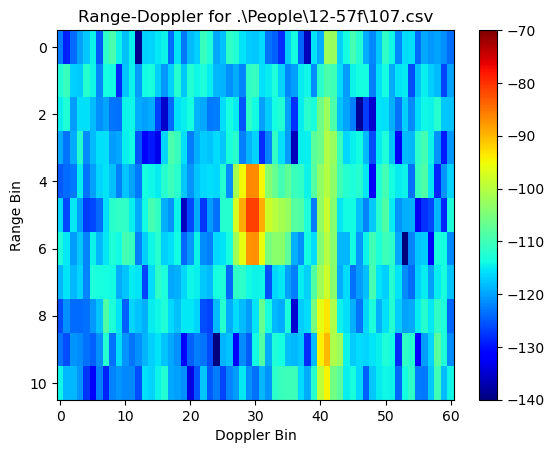

In [3]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[16300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[16299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Drone Sample

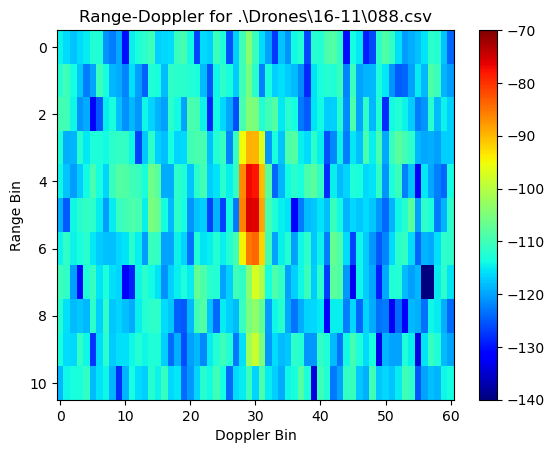

In [4]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[10300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[10299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Car Sample

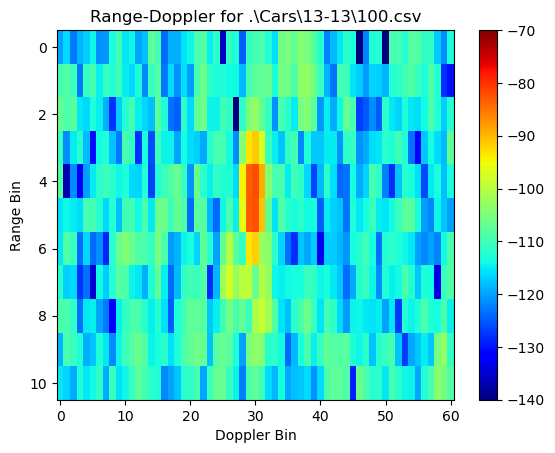

In [5]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[100], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[99]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Data Preprocessing

In [6]:
# Preprocessing the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train_original, x_test_original, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=31, shuffle=True)

x_train_original_shape = x_train_original.shape

# Reshape the data to 2D
x_train_reshaped = x_train_original.reshape(x_train_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)

# Reshape the data back to its original shape
x_train = x_train_scaled.reshape(x_train_original_shape)

# X_test scaling 
x_test_original_shape = x_test_original.shape

# Reshape the data to 2D
x_test_reshaped = x_test_original.reshape(x_test_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test_reshaped)

# Reshape the data back to its original shape
x_test = x_test_scaled.reshape(x_test_original_shape)

# Defining the Utility Functions to Plot Accuracies and Losses

In [7]:
##Defining utility functions to plot Accuracies and Losses

def smooth_curve(points,factor = 0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points

def plot_convergence():
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.plot(smooth_curve(history.history['accuracy']), marker= 'o', label = 'Train Accuracy')
  plt.plot(smooth_curve(history.history['val_accuracy']), marker= 'o', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(smooth_curve(history.history['loss']),marker = 'o', label = 'Train Loss')
  plt.plot(smooth_curve(history.history['val_loss']),marker = 'o', label = 'Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def test_model_accuracy(model):
  test_loss,test_accuracy = model.evaluate(x_test_rnn, y_test_rnn)
  print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
  plot_convergence()

## Reshaping the Data for Feeding the RNN

In [8]:
import numpy as np

def reshape_for_rnn(X, y, time_steps):
    # Get the original shape
    samples, height, width = X.shape
    
    # Reshape X to (samples, time_steps, features)
    X_reshaped = X.reshape(samples, time_steps, height * width // time_steps)
    
    # Convert y to one-hot encoded format
    y_onehot = np.eye(np.max(y) + 1)[y]
    
    return X_reshaped, y_onehot

x_train_rnn, y_train_rnn = reshape_for_rnn(x_train, y_train, time_steps=11)
x_test_rnn, y_test_rnn = reshape_for_rnn(x_test, y_test, time_steps=11)

## Building Recurrent Neural Network

### One RNN and One Output Layer for Classification

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 64)                8064      
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8,259
Trainable params: 8,259
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 5s 12ms/step - loss: 0.4748 - accuracy: 0.8057 - val_loss: 0.3056 - val_accuracy: 0.8785
Epoch 2/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2653 - accuracy: 0.8979 - val_loss: 0.2760 - val_accuracy: 0.8989
Epoch 3/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2185 - accuracy: 0.9187 - val_loss: 0.2502 - val_accuracy: 0.9028
Epoch 4/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1848 - accuracy: 0.9288 - val_loss: 0.2425 - val_accuracy: 0.9132
Epoch 5/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1607 - accuracy: 0.9410 - val_loss: 0.2373 - val_accuracy: 0.9146
Epoch 6/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1445 - accuracy: 0.9469 - val_loss: 0.2306 - val_accuracy: 0.9124
Epoch 7/30
350/350 [==============================] - 2s 4ms/step - loss: 0.1290 - accuracy: 0.9532 - val_loss: 0.2301 - val_accuracy: 0.9124
Epoch

110/110 [==============================] - 0s 2ms/step - loss: 0.4420 - accuracy: 0.9182
Test Accuracy: 91.8216%


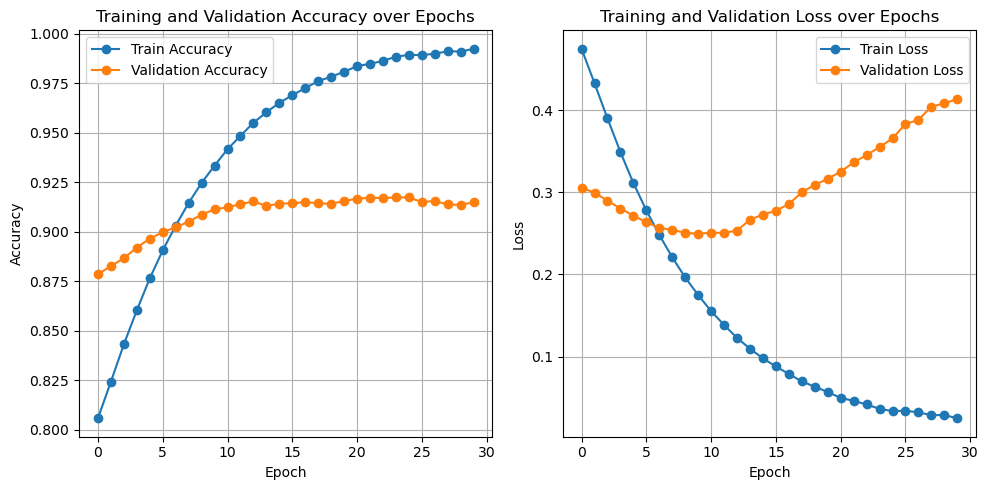

In [30]:
test_model_accuracy(model)

### One RNN and One Dense Layer for Classification

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 64)                8064      
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                                 
Total params: 9,155
Trainable params: 9,155
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 11s 30ms/step - loss: 0.5401 - accuracy: 0.7775 - val_loss: 0.3351 - val_accuracy: 0.8724
Epoch 2/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2695 - accuracy: 0.8978 - val_loss: 0.2508 - val_accuracy: 0.9046
Epoch 3/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2128 - accuracy: 0.9183 - val_loss: 0.2529 - val_accuracy: 0.9049
Epoch 4/30
350/350 [==============================] - 2s 4ms/step - loss: 0.1761 - accuracy: 0.9326 - val_loss: 0.2228 - val_accuracy: 0.9182
Epoch 5/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1529 - accuracy: 0.9406 - val_loss: 0.2307 - val_accuracy: 0.9182
Epoch 6/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1345 - accuracy: 0.9506 - val_loss: 0.2289 - val_accuracy: 0.9110
Epoch 7/30
350/350 [==============================] - 2s 5ms/step - loss: 0.1178 - accuracy: 0.9562 - val_loss: 0.2268 - val_accuracy: 0.9149
Epoc

110/110 [==============================] - 0s 2ms/step - loss: 0.4584 - accuracy: 0.9179
Test Accuracy: 91.7930%


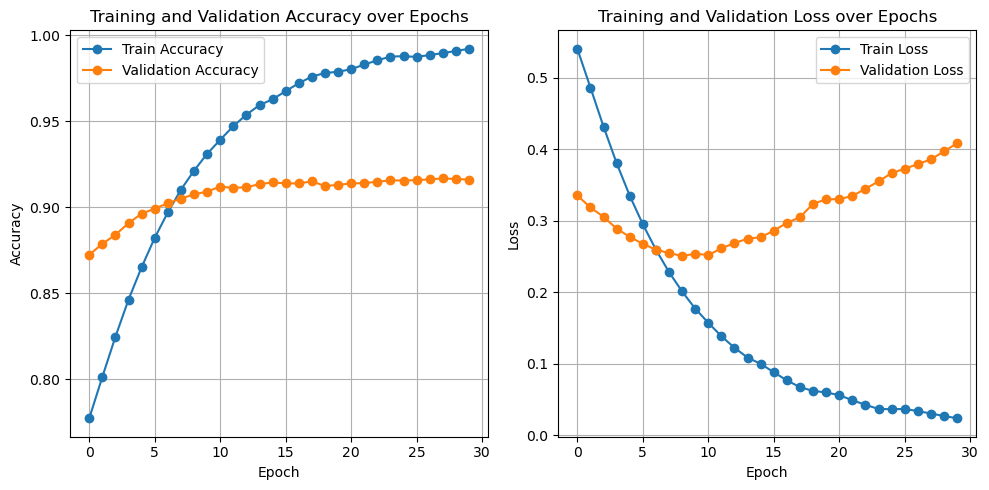

In [27]:
test_model_accuracy(model)

### One RNN and Two Dense Layer for Classification

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 64)                8064      
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 3)                 51        
                                                                 
Total params: 9,427
Trainable params: 9,427
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 3s 5ms/step - loss: 0.5537 - accuracy: 0.7743 - val_loss: 0.3378 - val_accuracy: 0.8724
Epoch 2/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2920 - accuracy: 0.8828 - val_loss: 0.2802 - val_accuracy: 0.8949
Epoch 3/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2244 - accuracy: 0.9120 - val_loss: 0.2580 - val_accuracy: 0.9056
Epoch 4/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1947 - accuracy: 0.9223 - val_loss: 0.2337 - val_accuracy: 0.9092
Epoch 5/30
350/350 [==============================] - 2s 4ms/step - loss: 0.1680 - accuracy: 0.9347 - val_loss: 0.2407 - val_accuracy: 0.9078
Epoch 6/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1447 - accuracy: 0.9429 - val_loss: 0.2226 - val_accuracy: 0.9146
Epoch 7/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1267 - accuracy: 0.9513 - val_loss: 0.2329 - val_accuracy: 0.9224
Epoch 

110/110 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.9168
Test Accuracy: 91.6786%


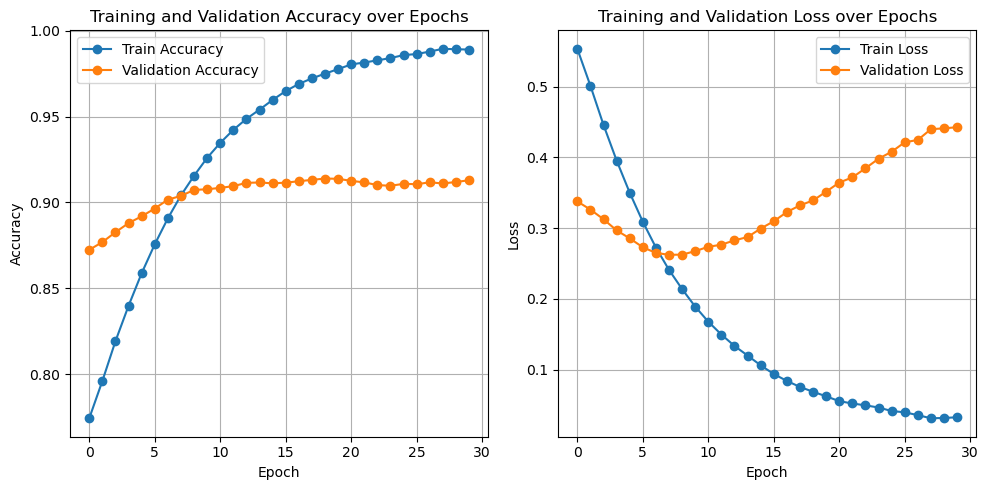

In [33]:
test_model_accuracy(model)

### One RNN and Three Dense Layer for Classification

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 64)                8064      
                                                                 
 dense_11 (Dense)            (None, 16)                1040      
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 3)                 51        
                                                                 
Total params: 9,699
Trainable params: 9,699
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 3s 5ms/step - loss: 0.5333 - accuracy: 0.7776 - val_loss: 0.3109 - val_accuracy: 0.8767
Epoch 2/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2783 - accuracy: 0.8912 - val_loss: 0.2677 - val_accuracy: 0.9010
Epoch 3/30
350/350 [==============================] - 1s 4ms/step - loss: 0.2196 - accuracy: 0.9158 - val_loss: 0.2302 - val_accuracy: 0.9153
Epoch 4/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1851 - accuracy: 0.9298 - val_loss: 0.2303 - val_accuracy: 0.9167
Epoch 5/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1572 - accuracy: 0.9396 - val_loss: 0.2292 - val_accuracy: 0.9199
Epoch 6/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1434 - accuracy: 0.9445 - val_loss: 0.2235 - val_accuracy: 0.9207
Epoch 7/30
350/350 [==============================] - 1s 4ms/step - loss: 0.1254 - accuracy: 0.9529 - val_loss: 0.2221 - val_accuracy: 0.9260
Epoch 

110/110 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.9105
Test Accuracy: 91.0495%


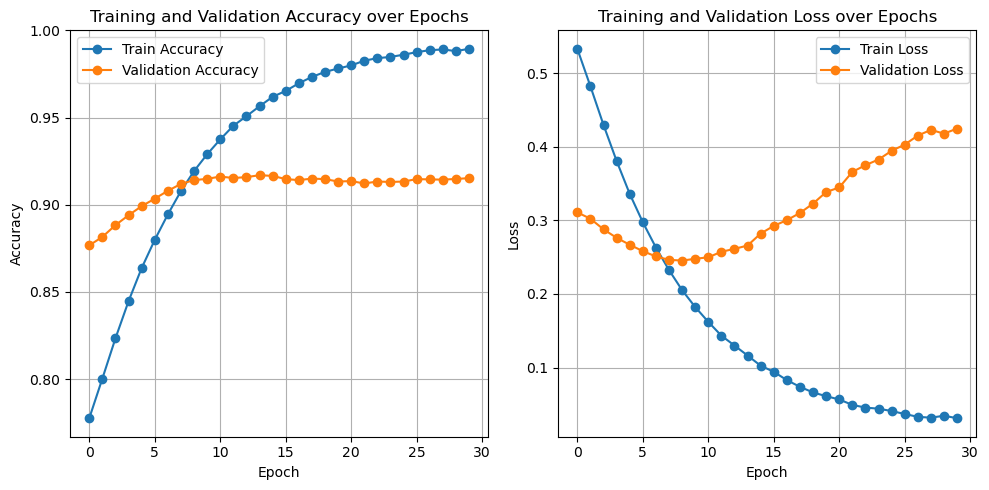

In [36]:
test_model_accuracy(model)

### Two RNNs and One Dense Layer for Classification

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 11, 64)            8064      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 11,747
Trainable params: 11,747
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 6s 10ms/step - loss: 0.5024 - accuracy: 0.8008 - val_loss: 0.3076 - val_accuracy: 0.8813
Epoch 2/30
350/350 [==============================] - 2s 6ms/step - loss: 0.2677 - accuracy: 0.8901 - val_loss: 0.2629 - val_accuracy: 0.8896
Epoch 3/30
350/350 [==============================] - 2s 6ms/step - loss: 0.2110 - accuracy: 0.9152 - val_loss: 0.2304 - val_accuracy: 0.9078
Epoch 4/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1722 - accuracy: 0.9306 - val_loss: 0.2550 - val_accuracy: 0.8899
Epoch 5/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1455 - accuracy: 0.9446 - val_loss: 0.2177 - val_accuracy: 0.9217
Epoch 6/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1287 - accuracy: 0.9492 - val_loss: 0.2151 - val_accuracy: 0.9253
Epoch 7/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1053 - accuracy: 0.9602 - val_loss: 0.2390 - val_accuracy: 0.9096
Epoch

110/110 [==============================] - 0s 2ms/step - loss: 0.3952 - accuracy: 0.9185
Test Accuracy: 91.8502%


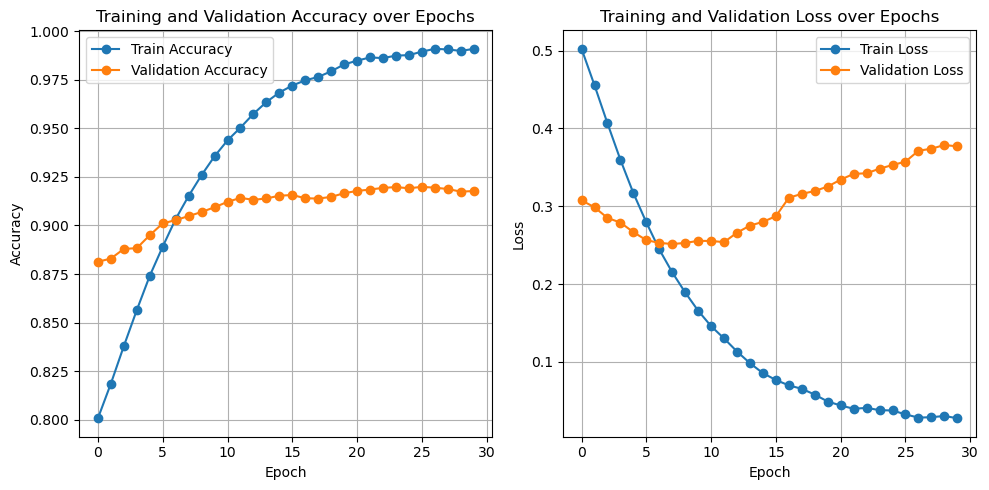

In [20]:
test_model_accuracy(model)

### Two RNNs and Two Dense Layer for Classification

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 11, 64)            8064      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 3)                 51        
                                                                 
Total params: 12,019
Trainable params: 12,019
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 17s 35ms/step - loss: 0.5269 - accuracy: 0.7943 - val_loss: 0.3256 - val_accuracy: 0.8771
Epoch 2/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2741 - accuracy: 0.8959 - val_loss: 0.2556 - val_accuracy: 0.9010
Epoch 3/30
350/350 [==============================] - 2s 6ms/step - loss: 0.2110 - accuracy: 0.9210 - val_loss: 0.2297 - val_accuracy: 0.9121
Epoch 4/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1743 - accuracy: 0.9358 - val_loss: 0.2277 - val_accuracy: 0.9103
Epoch 5/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1500 - accuracy: 0.9445 - val_loss: 0.2373 - val_accuracy: 0.9099
Epoch 6/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1358 - accuracy: 0.9492 - val_loss: 0.2120 - val_accuracy: 0.9207
Epoch 7/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1142 - accuracy: 0.9601 - val_loss: 0.2161 - val_accuracy: 0.9210
Epoc

110/110 [==============================] - 0s 4ms/step - loss: 0.4237 - accuracy: 0.9179
Test Accuracy: 91.7930%


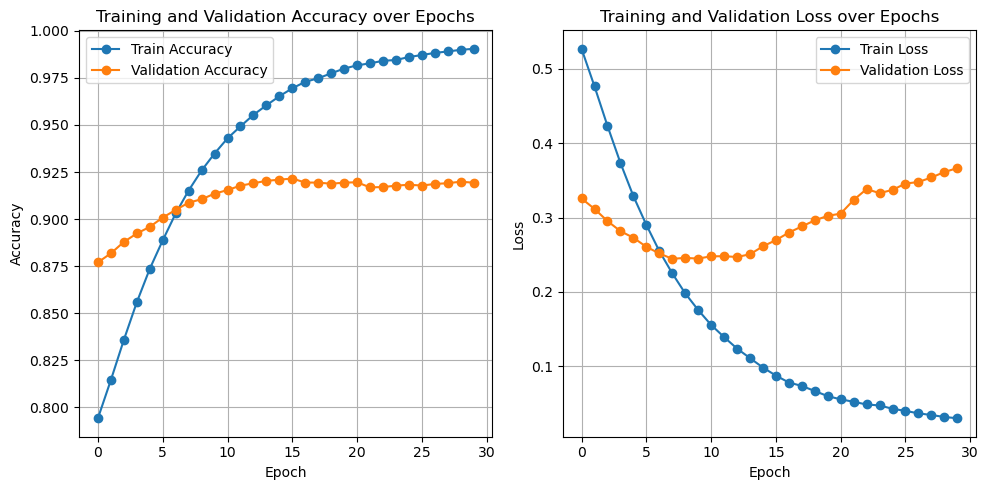

In [39]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 3)                 51        
                                                                 
Total params: 12,291
Trainable params: 12,291
Non-trai

In [41]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 5s 7ms/step - loss: 0.4756 - accuracy: 0.8067 - val_loss: 0.2860 - val_accuracy: 0.8903
Epoch 2/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2452 - accuracy: 0.9079 - val_loss: 0.2484 - val_accuracy: 0.9060
Epoch 3/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1994 - accuracy: 0.9253 - val_loss: 0.2201 - val_accuracy: 0.9199
Epoch 4/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1577 - accuracy: 0.9422 - val_loss: 0.2288 - val_accuracy: 0.9160
Epoch 5/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1418 - accuracy: 0.9481 - val_loss: 0.2479 - val_accuracy: 0.9185
Epoch 6/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1308 - accuracy: 0.9496 - val_loss: 0.2228 - val_accuracy: 0.9228
Epoch 7/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1191 - accuracy: 0.9564 - val_loss: 0.2306 - val_accuracy: 0.9196
Epoch 

110/110 [==============================] - 0s 4ms/step - loss: 0.4030 - accuracy: 0.9191
Test Accuracy: 91.9073%


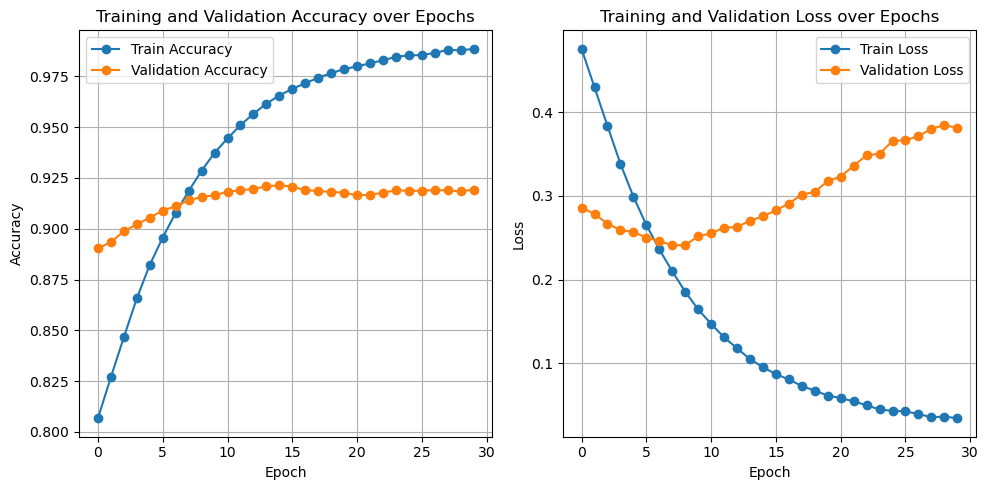

In [42]:
test_model_accuracy(model)

### Two RNNs and Four  Dense Layer for Classification

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 16)                272       
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 16)                272       
                                                                 
 dense_26 (Dense)            (None, 3)                

In [44]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 14s 32ms/step - loss: 0.5683 - accuracy: 0.7552 - val_loss: 0.3340 - val_accuracy: 0.8735
Epoch 2/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2909 - accuracy: 0.8873 - val_loss: 0.3040 - val_accuracy: 0.8849
Epoch 3/30
350/350 [==============================] - 2s 6ms/step - loss: 0.2230 - accuracy: 0.9145 - val_loss: 0.2490 - val_accuracy: 0.8974
Epoch 4/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1878 - accuracy: 0.9265 - val_loss: 0.2311 - val_accuracy: 0.9124
Epoch 5/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1643 - accuracy: 0.9362 - val_loss: 0.2319 - val_accuracy: 0.9110
Epoch 6/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1448 - accuracy: 0.9453 - val_loss: 0.2382 - val_accuracy: 0.9142
Epoch 7/30
350/350 [==============================] - 2s 6ms/step - loss: 0.1218 - accuracy: 0.9539 - val_loss: 0.2470 - val_accuracy: 0.9153
Epoc

110/110 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.9185
Test Accuracy: 91.8502%


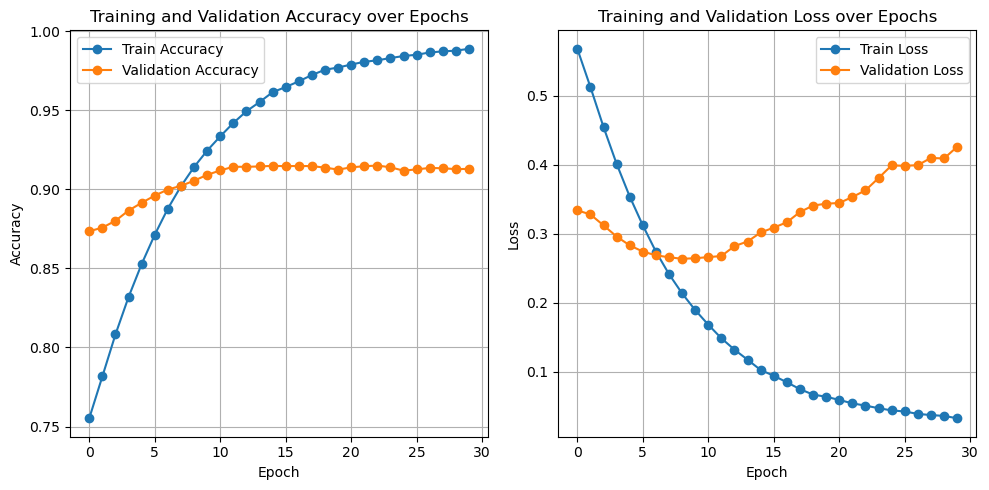

In [45]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification (Selected for Next Stage)
#### Testing this selected model with Batch Size 64

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 16)                272       
                                                                 
 dense_37 (Dense)            (None, 16)                272       
                                                                 
 dense_38 (Dense)            (None, 3)                 51        
                                                                 
Total params: 12,291
Trainable params: 12,291
Non-tra

In [53]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 11ms/step - loss: 0.6043 - accuracy: 0.7388 - val_loss: 0.3430 - val_accuracy: 0.8663
Epoch 2/30
175/175 [==============================] - 1s 8ms/step - loss: 0.2850 - accuracy: 0.8891 - val_loss: 0.2691 - val_accuracy: 0.8924
Epoch 3/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2157 - accuracy: 0.9159 - val_loss: 0.2517 - val_accuracy: 0.9067
Epoch 4/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1832 - accuracy: 0.9301 - val_loss: 0.2490 - val_accuracy: 0.9092
Epoch 5/30
175/175 [==============================] - 1s 8ms/step - loss: 0.1603 - accuracy: 0.9373 - val_loss: 0.2327 - val_accuracy: 0.9196
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1392 - accuracy: 0.9478 - val_loss: 0.2202 - val_accuracy: 0.9207
Epoch 7/30
175/175 [==============================] - 1s 8ms/step - loss: 0.1206 - accuracy: 0.9536 - val_loss: 0.2295 - val_accuracy: 0.9203
Epoc

110/110 [==============================] - 0s 3ms/step - loss: 0.4334 - accuracy: 0.9214
Test Accuracy: 92.1361%


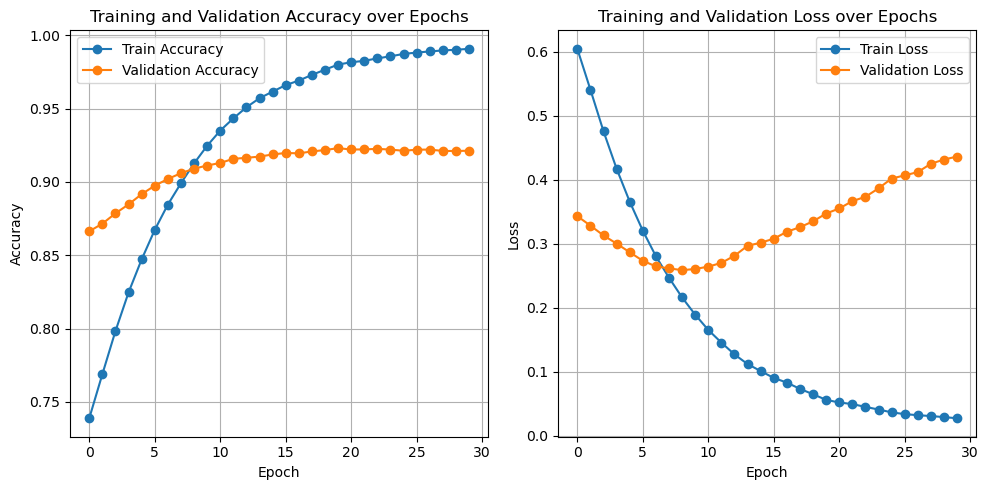

In [54]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification (Selected for Next Stage)
#### Testing this selected model with Batch Size 16

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dense_40 (Dense)            (None, 16)                272       
                                                                 
 dense_41 (Dense)            (None, 16)                272       
                                                                 
 dense_42 (Dense)            (None, 3)                 51        
                                                                 
Total params: 12,291
Trainable params: 12,291
Non-tra

In [56]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=16)

Epoch 1/30
700/700 [==============================] - 6s 7ms/step - loss: 0.4528 - accuracy: 0.8143 - val_loss: 0.2851 - val_accuracy: 0.8874
Epoch 2/30
700/700 [==============================] - 4s 6ms/step - loss: 0.2361 - accuracy: 0.9106 - val_loss: 0.2286 - val_accuracy: 0.9117
Epoch 3/30
700/700 [==============================] - 4s 6ms/step - loss: 0.1886 - accuracy: 0.9298 - val_loss: 0.2231 - val_accuracy: 0.9142
Epoch 4/30
700/700 [==============================] - 4s 6ms/step - loss: 0.1636 - accuracy: 0.9371 - val_loss: 0.2205 - val_accuracy: 0.9217
Epoch 5/30
700/700 [==============================] - 4s 6ms/step - loss: 0.1427 - accuracy: 0.9462 - val_loss: 0.2282 - val_accuracy: 0.9203
Epoch 6/30
700/700 [==============================] - 4s 6ms/step - loss: 0.1279 - accuracy: 0.9518 - val_loss: 0.2254 - val_accuracy: 0.9249
Epoch 7/30
700/700 [==============================] - 4s 6ms/step - loss: 0.1212 - accuracy: 0.9556 - val_loss: 0.2287 - val_accuracy: 0.9260
Epoch 

110/110 [==============================] - 0s 3ms/step - loss: 0.3911 - accuracy: 0.9196
Test Accuracy: 91.9645%


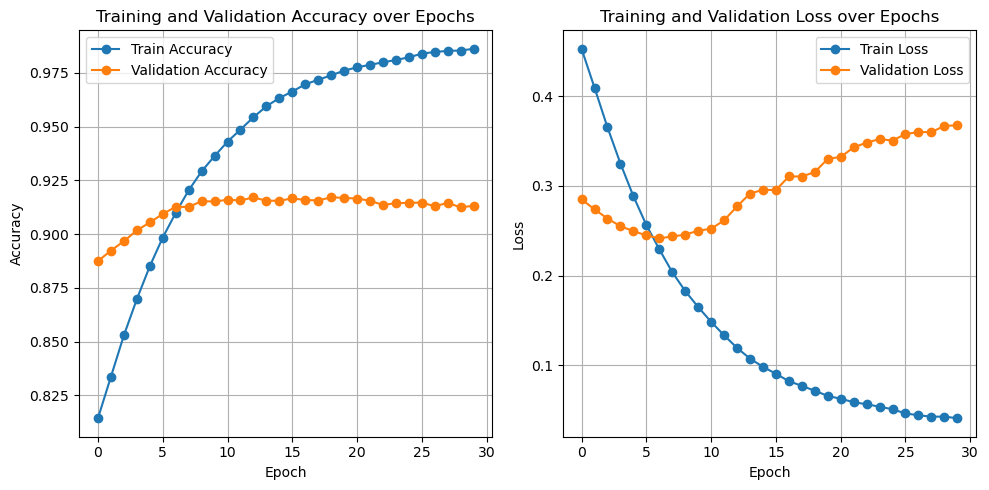

In [57]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification 
#### Testing with Different Weigths (Dense Layers Weights Set 32)

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_45 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_46 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_83 (Dense)            (None, 32)                1056      
                                                                 
 dense_84 (Dense)            (None, 32)                1056      
                                                                 
 dense_85 (Dense)            (None, 32)                1056      
                                                                 
 dense_86 (Dense)            (None, 3)                 99        
                                                                 
Total params: 14,435
Trainable params: 14,435
Non-tra

In [89]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 13ms/step - loss: 0.5415 - accuracy: 0.7711 - val_loss: 0.2987 - val_accuracy: 0.8871
Epoch 2/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2619 - accuracy: 0.8999 - val_loss: 0.2511 - val_accuracy: 0.9089
Epoch 3/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1988 - accuracy: 0.9254 - val_loss: 0.2299 - val_accuracy: 0.9171
Epoch 4/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1670 - accuracy: 0.9395 - val_loss: 0.2523 - val_accuracy: 0.9114
Epoch 5/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1481 - accuracy: 0.9458 - val_loss: 0.2364 - val_accuracy: 0.9214
Epoch 6/30
175/175 [==============================] - 2s 13ms/step - loss: 0.1243 - accuracy: 0.9559 - val_loss: 0.2691 - val_accuracy: 0.8978
Epoch 7/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1075 - accuracy: 0.9619 - val_loss: 0.2421 - val_accuracy: 0.9203
E

110/110 [==============================] - 0s 4ms/step - loss: 0.5306 - accuracy: 0.9065
Test Accuracy: 90.6491%


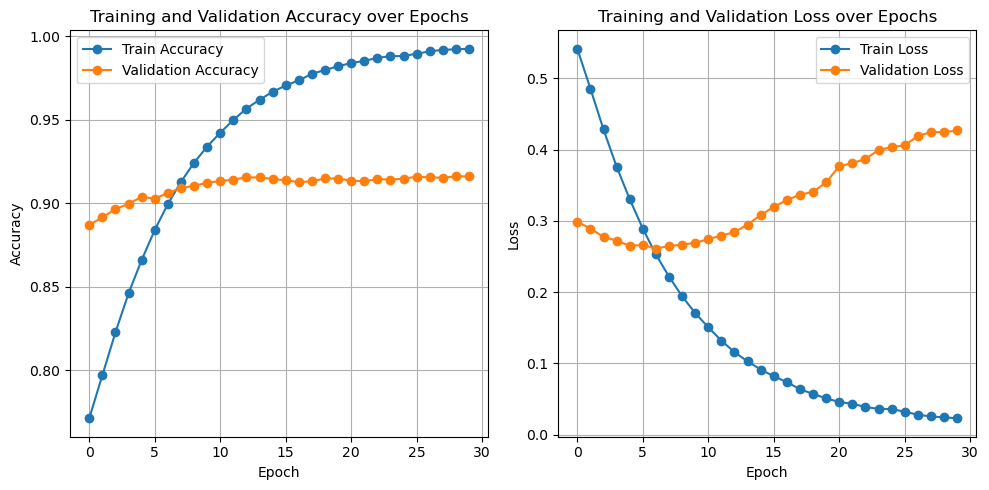

In [90]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification
#### Testing with Different Weigths (Dense Layers Weights Set 64)

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_49 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_50 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_91 (Dense)            (None, 64)                2112      
                                                                 
 dense_92 (Dense)            (None, 64)                4160      
                                                                 
 dense_93 (Dense)            (None, 64)                4160      
                                                                 
 dense_94 (Dense)            (None, 3)                 195       
                                                                 
Total params: 21,795
Trainable params: 21,795
Non-tra

In [95]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 6s 12ms/step - loss: 0.5350 - accuracy: 0.7745 - val_loss: 0.3341 - val_accuracy: 0.8635
Epoch 2/30
175/175 [==============================] - 2s 11ms/step - loss: 0.2841 - accuracy: 0.8844 - val_loss: 0.2753 - val_accuracy: 0.8935
Epoch 3/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2290 - accuracy: 0.9068 - val_loss: 0.2879 - val_accuracy: 0.8964
Epoch 4/30
175/175 [==============================] - 2s 11ms/step - loss: 0.1925 - accuracy: 0.9242 - val_loss: 0.2420 - val_accuracy: 0.9092
Epoch 5/30
175/175 [==============================] - 2s 12ms/step - loss: 0.1597 - accuracy: 0.9374 - val_loss: 0.2342 - val_accuracy: 0.9160
Epoch 6/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1382 - accuracy: 0.9483 - val_loss: 0.2377 - val_accuracy: 0.9153
Epoch 7/30
175/175 [==============================] - 2s 11ms/step - loss: 0.1256 - accuracy: 0.9517 - val_loss: 0.2282 - val_accuracy: 0.9167

110/110 [==============================] - 0s 3ms/step - loss: 0.4661 - accuracy: 0.9134
Test Accuracy: 91.3354%


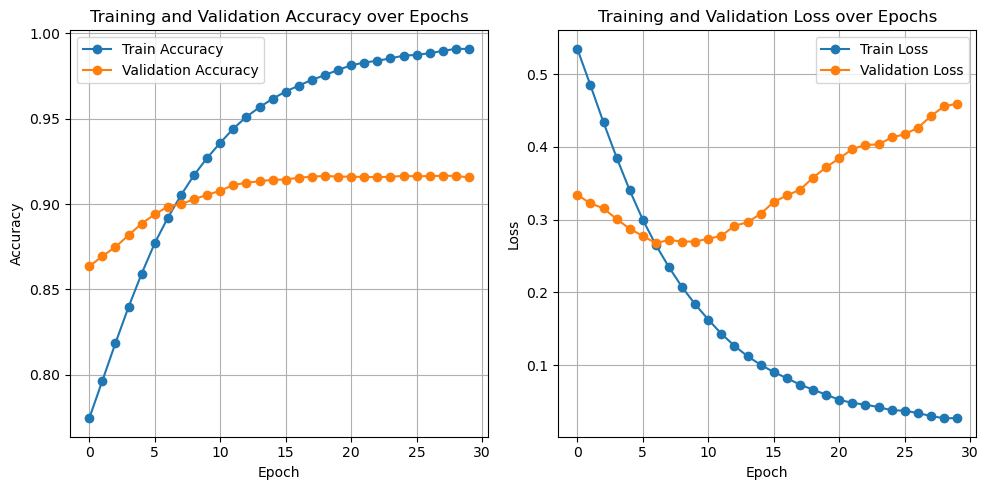

In [96]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification
#### Testing with Decrasing Weigths (Weights are decrasing from 64-to 16)

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_63 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_64 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_119 (Dense)           (None, 64)                2112      
                                                                 
 dense_120 (Dense)           (None, 32)                2080      
                                                                 
 dense_121 (Dense)           (None, 16)                528       
                                                                 
 dense_122 (Dense)           (None, 3)                 51        
                                                                 
Total params: 15,939
Trainable params: 15,939
Non-tra

In [117]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 14ms/step - loss: 0.5476 - accuracy: 0.7660 - val_loss: 0.3263 - val_accuracy: 0.8695
Epoch 2/30
175/175 [==============================] - 2s 11ms/step - loss: 0.2645 - accuracy: 0.8932 - val_loss: 0.2759 - val_accuracy: 0.8899
Epoch 3/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2097 - accuracy: 0.9161 - val_loss: 0.2540 - val_accuracy: 0.9017
Epoch 4/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1727 - accuracy: 0.9325 - val_loss: 0.2410 - val_accuracy: 0.9099
Epoch 5/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1453 - accuracy: 0.9458 - val_loss: 0.2463 - val_accuracy: 0.9078
Epoch 6/30
175/175 [==============================] - 1s 9ms/step - loss: 0.1366 - accuracy: 0.9498 - val_loss: 0.2418 - val_accuracy: 0.9135
Epoch 7/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1153 - accuracy: 0.9584 - val_loss: 0.2440 - val_accuracy: 0.9178
Epo

110/110 [==============================] - 0s 4ms/step - loss: 0.4733 - accuracy: 0.9188
Test Accuracy: 91.8788%


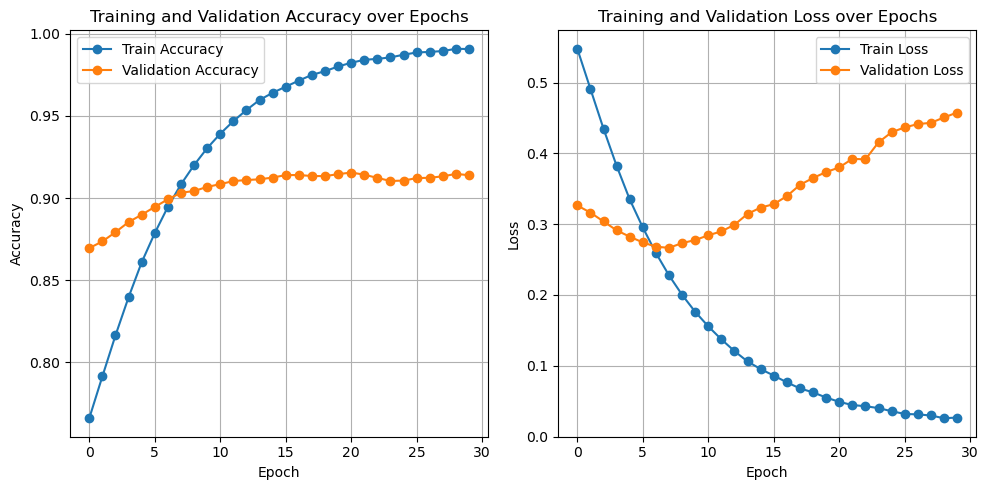

In [118]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification
#### Testing with Decrasing Weigths (Weights are decrasing set as  32 32  16)

In [150]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_85 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_86 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_163 (Dense)           (None, 32)                1056      
                                                                 
 dense_164 (Dense)           (None, 32)                1056      
                                                                 
 dense_165 (Dense)           (None, 16)                528       
                                                                 
 dense_166 (Dense)           (None, 3)                 51        
                                                                 
Total params: 13,859
Trainable params: 13,859
Non-tra

In [151]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 13ms/step - loss: 0.5769 - accuracy: 0.7571 - val_loss: 0.3302 - val_accuracy: 0.8760
Epoch 2/30
175/175 [==============================] - 1s 8ms/step - loss: 0.2901 - accuracy: 0.8861 - val_loss: 0.2662 - val_accuracy: 0.8949
Epoch 3/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2261 - accuracy: 0.9088 - val_loss: 0.2429 - val_accuracy: 0.9035
Epoch 4/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1891 - accuracy: 0.9266 - val_loss: 0.2184 - val_accuracy: 0.9153
Epoch 5/30
175/175 [==============================] - 1s 7ms/step - loss: 0.1593 - accuracy: 0.9390 - val_loss: 0.2093 - val_accuracy: 0.9228
Epoch 6/30
175/175 [==============================] - 1s 8ms/step - loss: 0.1353 - accuracy: 0.9468 - val_loss: 0.2194 - val_accuracy: 0.9199
Epoch 7/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1243 - accuracy: 0.9547 - val_loss: 0.2110 - val_accuracy: 0.9292
Epoc

110/110 [==============================] - 0s 4ms/step - loss: 0.4587 - accuracy: 0.9199
Test Accuracy: 91.9931%


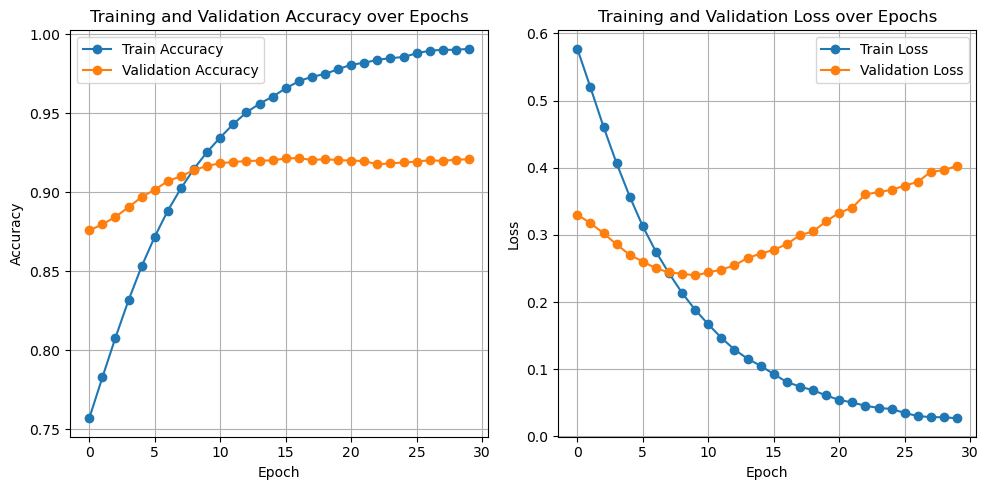

In [152]:
test_model_accuracy(model)

### Two RNNs and Three Dense Layer for Classification
#### Testing with Decrasing Weigths (Weights are decrasing set as  32 16  16)

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_79 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_80 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_151 (Dense)           (None, 32)                1056      
                                                                 
 dense_152 (Dense)           (None, 16)                528       
                                                                 
 dense_153 (Dense)           (None, 16)                272       
                                                                 
 dense_154 (Dense)           (None, 3)                 51        
                                                                 
Total params: 13,075
Trainable params: 13,075
Non-tra

In [142]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 12ms/step - loss: 0.5631 - accuracy: 0.7708 - val_loss: 0.3614 - val_accuracy: 0.8574
Epoch 2/30
175/175 [==============================] - 2s 10ms/step - loss: 0.3104 - accuracy: 0.8757 - val_loss: 0.3136 - val_accuracy: 0.8749
Epoch 3/30
175/175 [==============================] - 1s 8ms/step - loss: 0.2516 - accuracy: 0.8982 - val_loss: 0.2572 - val_accuracy: 0.9035
Epoch 4/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2058 - accuracy: 0.9181 - val_loss: 0.2692 - val_accuracy: 0.8999
Epoch 5/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1756 - accuracy: 0.9309 - val_loss: 0.2856 - val_accuracy: 0.8939
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1509 - accuracy: 0.9425 - val_loss: 0.2437 - val_accuracy: 0.9110
Epoch 7/30
175/175 [==============================] - 1s 8ms/step - loss: 0.1292 - accuracy: 0.9501 - val_loss: 0.2561 - val_accuracy: 0.9107
Epoc

110/110 [==============================] - 0s 3ms/step - loss: 0.4408 - accuracy: 0.9202
Test Accuracy: 92.0217%


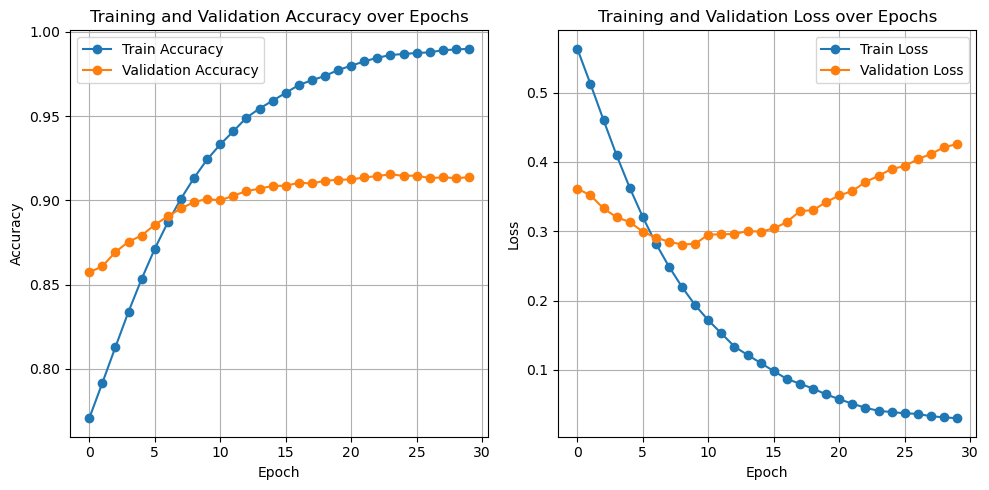

In [143]:
test_model_accuracy(model)

### Adding one More RNN 
#### Three RNNs and Three Dense Layer and Output Layer

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh',return_sequences=True),
    SimpleRNN(16, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_34 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 11, 32)            3104      
                                                                 
 simple_rnn_36 (SimpleRNN)   (None, 16)                784       
                                                                 
 dense_63 (Dense)            (None, 16)                272       
                                                                 
 dense_64 (Dense)            (None, 16)                272       
                                                                 
 dense_65 (Dense)            (None, 16)                272       
                                                                 
 dense_66 (Dense)            (None, 3)               

In [74]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 5s 16ms/step - loss: 0.6513 - accuracy: 0.7458 - val_loss: 0.3958 - val_accuracy: 0.8617
Epoch 2/30
175/175 [==============================] - 2s 10ms/step - loss: 0.3260 - accuracy: 0.8807 - val_loss: 0.3044 - val_accuracy: 0.8878
Epoch 3/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2525 - accuracy: 0.9027 - val_loss: 0.2581 - val_accuracy: 0.9035
Epoch 4/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2085 - accuracy: 0.9214 - val_loss: 0.2287 - val_accuracy: 0.9135
Epoch 5/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1744 - accuracy: 0.9377 - val_loss: 0.2361 - val_accuracy: 0.9128
Epoch 6/30
175/175 [==============================] - 2s 12ms/step - loss: 0.1519 - accuracy: 0.9460 - val_loss: 0.2265 - val_accuracy: 0.9210
Epoch 7/30
175/175 [==============================] - 2s 11ms/step - loss: 0.1273 - accuracy: 0.9551 - val_loss: 0.2373 - val_accuracy: 0.9232

110/110 [==============================] - 0s 3ms/step - loss: 0.4086 - accuracy: 0.9116
Test Accuracy: 91.1639%


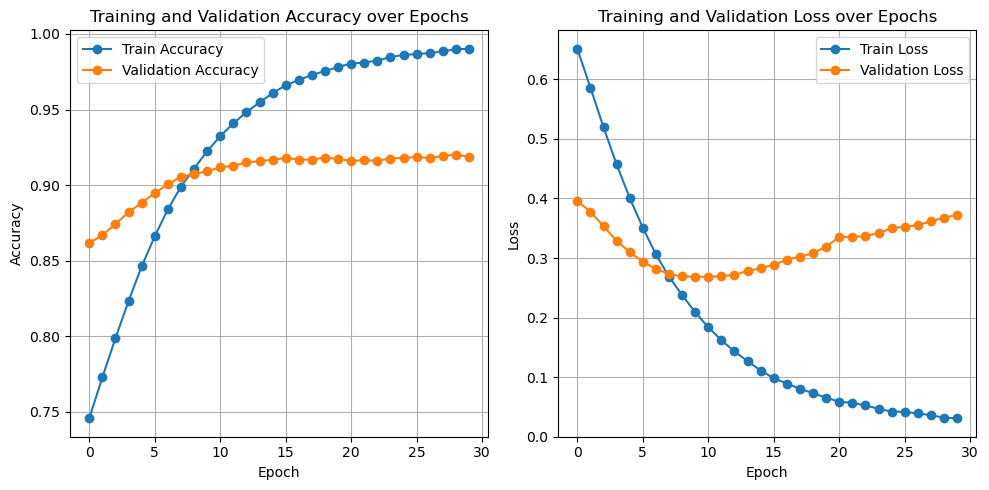

In [75]:
test_model_accuracy(model)

### Adding Flatten Layer

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_43 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 simple_rnn_44 (SimpleRNN)   (None, 32)                3104      
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dense_79 (Dense)            (None, 16)                528       
                                                                 
 dense_80 (Dense)            (None, 16)                272       
                                                                 
 dense_81 (Dense)            (None, 16)                272       
                                                                 
 dense_82 (Dense)            (None, 3)               

In [86]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 13ms/step - loss: 0.5786 - accuracy: 0.7528 - val_loss: 0.3187 - val_accuracy: 0.8728
Epoch 2/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2791 - accuracy: 0.8916 - val_loss: 0.2547 - val_accuracy: 0.8992
Epoch 3/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2198 - accuracy: 0.9156 - val_loss: 0.2373 - val_accuracy: 0.9121
Epoch 4/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1860 - accuracy: 0.9315 - val_loss: 0.2313 - val_accuracy: 0.9139
Epoch 5/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1591 - accuracy: 0.9404 - val_loss: 0.2247 - val_accuracy: 0.9189
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1365 - accuracy: 0.9488 - val_loss: 0.2310 - val_accuracy: 0.9153
Epoch 7/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1223 - accuracy: 0.9546 - val_loss: 0.2451 - val_accuracy: 0.9135
Epo

110/110 [==============================] - 0s 3ms/step - loss: 0.4521 - accuracy: 0.9168
Test Accuracy: 91.6786%


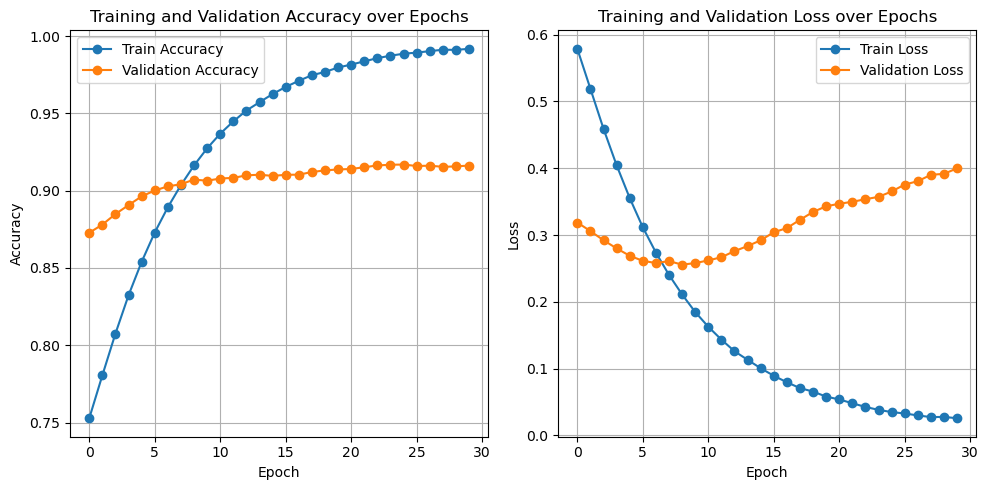

In [87]:
test_model_accuracy(model)

## Adding Batch Normalization
### Only 1 Batch Normalization Layer After First RNN

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalMaxPooling1D, TimeDistributed, MaxPooling1D

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_117 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_13 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_118 (SimpleRNN)  (None, 32)                3104      
                                                                 
 dense_227 (Dense)           (None, 16)                528       
                                                                 
 dense_228 (Dense)           (None, 16)                272       
                                                                 
 dense_229 (Dense)           (None, 16)                272       
                                                     

In [191]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 5s 14ms/step - loss: 0.6920 - accuracy: 0.6880 - val_loss: 0.3776 - val_accuracy: 0.8653
Epoch 2/30
175/175 [==============================] - 3s 15ms/step - loss: 0.3244 - accuracy: 0.8705 - val_loss: 0.2978 - val_accuracy: 0.8881
Epoch 3/30
175/175 [==============================] - 2s 11ms/step - loss: 0.2639 - accuracy: 0.8913 - val_loss: 0.2834 - val_accuracy: 0.8921
Epoch 4/30
175/175 [==============================] - 2s 14ms/step - loss: 0.2292 - accuracy: 0.9072 - val_loss: 0.2640 - val_accuracy: 0.8981
Epoch 5/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2003 - accuracy: 0.9194 - val_loss: 0.2595 - val_accuracy: 0.9042
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1767 - accuracy: 0.9281 - val_loss: 0.2500 - val_accuracy: 0.9046
Epoch 7/30
175/175 [==============================] - 2s 11ms/step - loss: 0.1556 - accuracy: 0.9413 - val_loss: 0.2401 - val_accuracy: 0.9121


110/110 [==============================] - 0s 3ms/step - loss: 0.3766 - accuracy: 0.9139
Test Accuracy: 91.3926%


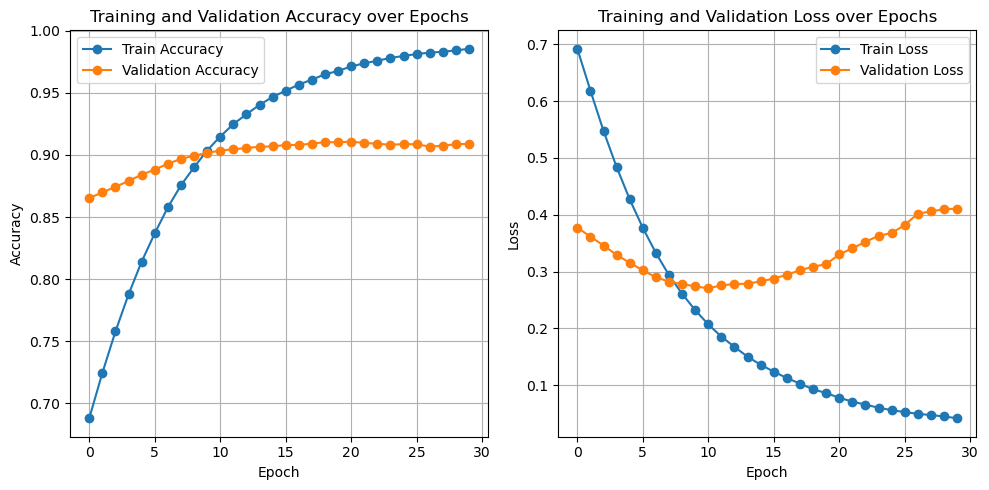

In [192]:
test_model_accuracy(model)

## Adding Batch Normalization
### Only 1 Batch Normalization Layer After Second RNN

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalMaxPooling1D, TimeDistributed, MaxPooling1D

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(32, activation='tanh'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_125 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 simple_rnn_126 (SimpleRNN)  (None, 32)                3104      
                                                                 
 batch_normalization_18 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_243 (Dense)           (None, 16)                528       
                                                                 
 dense_244 (Dense)           (None, 16)                272       
                                                                 
 dense_245 (Dense)           (None, 16)                272       
                                                     

In [204]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 4s 12ms/step - loss: 0.6208 - accuracy: 0.7412 - val_loss: 0.3918 - val_accuracy: 0.8435
Epoch 2/30
175/175 [==============================] - 2s 9ms/step - loss: 0.3163 - accuracy: 0.8795 - val_loss: 0.3166 - val_accuracy: 0.8592
Epoch 3/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2507 - accuracy: 0.9000 - val_loss: 0.2516 - val_accuracy: 0.9060
Epoch 4/30
175/175 [==============================] - 1s 8ms/step - loss: 0.2064 - accuracy: 0.9195 - val_loss: 0.2409 - val_accuracy: 0.9103
Epoch 5/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1831 - accuracy: 0.9288 - val_loss: 0.2373 - val_accuracy: 0.9164
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1566 - accuracy: 0.9392 - val_loss: 0.2471 - val_accuracy: 0.9128
Epoch 7/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1440 - accuracy: 0.9456 - val_loss: 0.2267 - val_accuracy: 0.9171
Epoc

110/110 [==============================] - 0s 3ms/step - loss: 0.3771 - accuracy: 0.9188
Test Accuracy: 91.8788%


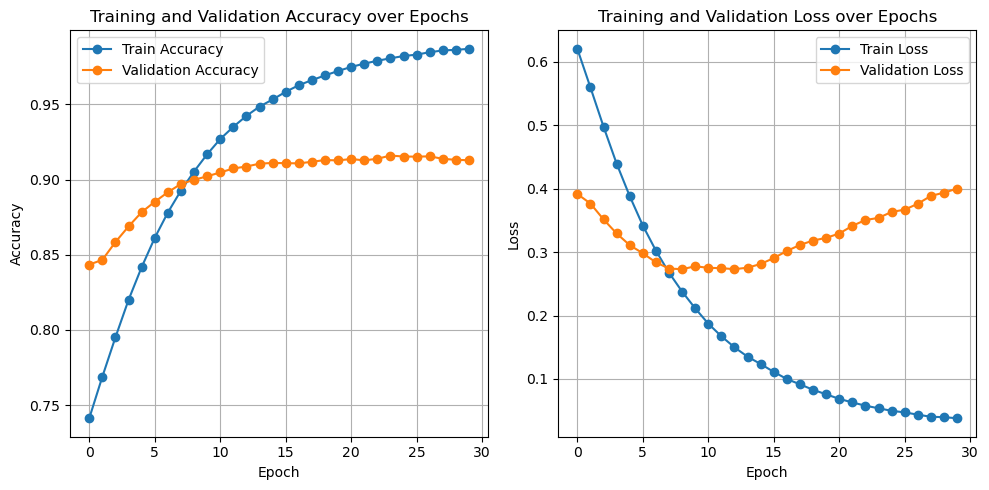

In [205]:
test_model_accuracy(model)

## Adding Batch Normalization
### 2 Batch Normalization Layers

In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalMaxPooling1D, TimeDistributed, MaxPooling1D

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    
    BatchNormalization(),
   
    SimpleRNN(32, activation='tanh'),

    BatchNormalization(),
   
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_127 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_19 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_128 (SimpleRNN)  (None, 32)                3104      
                                                                 
 batch_normalization_20 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_247 (Dense)           (None, 16)                528       
                                                                 
 dense_248 (Dense)           (None, 16)              

In [207]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 5s 14ms/step - loss: 0.6449 - accuracy: 0.7133 - val_loss: 0.3823 - val_accuracy: 0.8549
Epoch 2/30
175/175 [==============================] - 2s 10ms/step - loss: 0.3130 - accuracy: 0.8766 - val_loss: 0.3039 - val_accuracy: 0.8792
Epoch 3/30
175/175 [==============================] - 1s 9ms/step - loss: 0.2518 - accuracy: 0.8985 - val_loss: 0.2751 - val_accuracy: 0.8921
Epoch 4/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2200 - accuracy: 0.9120 - val_loss: 0.2417 - val_accuracy: 0.9074
Epoch 5/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1881 - accuracy: 0.9265 - val_loss: 0.2805 - val_accuracy: 0.8999
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1774 - accuracy: 0.9337 - val_loss: 0.2292 - val_accuracy: 0.9174
Epoch 7/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1508 - accuracy: 0.9416 - val_loss: 0.2400 - val_accuracy: 0.9178
Ep

110/110 [==============================] - 0s 3ms/step - loss: 0.3743 - accuracy: 0.9159
Test Accuracy: 91.5928%


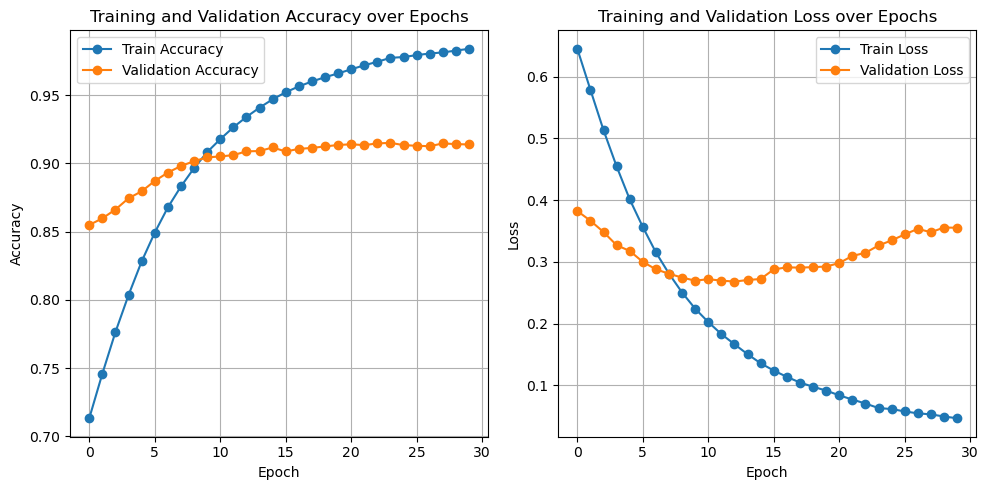

In [208]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Max Pooling Layers

In [219]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalMaxPooling1D, TimeDistributed, MaxPooling1D, BatchNormalization

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    
    MaxPooling1D(pool_size=2),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_138 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_30 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 simple_rnn_139 (SimpleRNN)  (None, 5, 32)             3104      
                                                                 
 batch_normalization_31 (Bat  (None, 5, 32)            128       
 chNormalization)                                                
                                                     

In [220]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 5s 12ms/step - loss: 0.6901 - accuracy: 0.6993 - val_loss: 0.4301 - val_accuracy: 0.8317
Epoch 2/30
175/175 [==============================] - 2s 11ms/step - loss: 0.3456 - accuracy: 0.8595 - val_loss: 0.3572 - val_accuracy: 0.8620
Epoch 3/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2669 - accuracy: 0.8892 - val_loss: 0.3425 - val_accuracy: 0.8645
Epoch 4/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2248 - accuracy: 0.9073 - val_loss: 0.3189 - val_accuracy: 0.8760
Epoch 5/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1969 - accuracy: 0.9154 - val_loss: 0.3234 - val_accuracy: 0.8767
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1701 - accuracy: 0.9275 - val_loss: 0.3179 - val_accuracy: 0.8835
Epoch 7/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1446 - accuracy: 0.9388 - val_loss: 0.3559 - val_accuracy: 0.8835
Epo

110/110 [==============================] - 0s 4ms/step - loss: 0.5673 - accuracy: 0.8890
Test Accuracy: 88.9048%


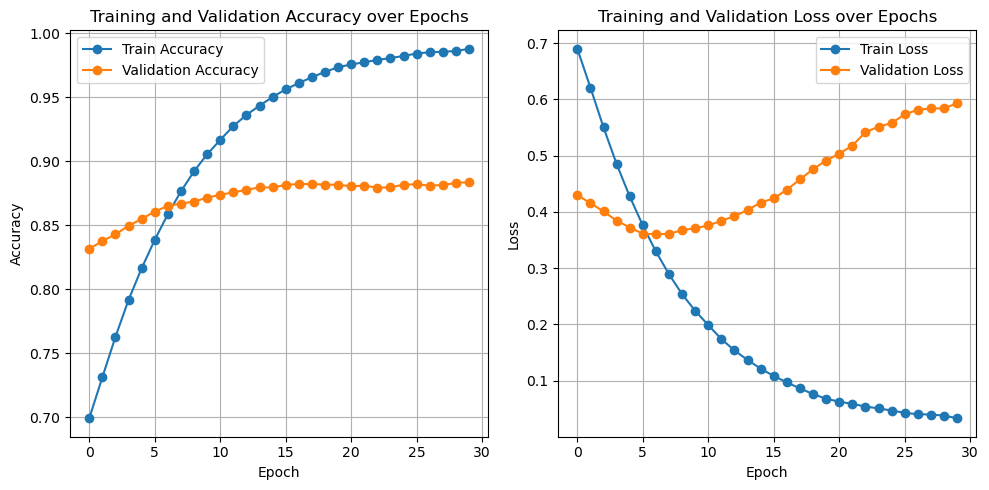

In [221]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Average Pooling Layers

In [225]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    
    AveragePooling1D(pool_size=2),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_142 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_34 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_2 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                                 
 simple_rnn_143 (SimpleRNN)  (None, 5, 32)             3104      
                                                                 
 batch_normalization_35 (Bat  (None, 5, 32)            128       
 chNormalization)                                                
                                                     

In [226]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 5s 14ms/step - loss: 0.6632 - accuracy: 0.7201 - val_loss: 0.4343 - val_accuracy: 0.8249
Epoch 2/30
175/175 [==============================] - 2s 9ms/step - loss: 0.3371 - accuracy: 0.8664 - val_loss: 0.3113 - val_accuracy: 0.8746
Epoch 3/30
175/175 [==============================] - 2s 9ms/step - loss: 0.2713 - accuracy: 0.8902 - val_loss: 0.2813 - val_accuracy: 0.8903
Epoch 4/30
175/175 [==============================] - 2s 10ms/step - loss: 0.2268 - accuracy: 0.9074 - val_loss: 0.2507 - val_accuracy: 0.8989
Epoch 5/30
175/175 [==============================] - 1s 8ms/step - loss: 0.1930 - accuracy: 0.9239 - val_loss: 0.2600 - val_accuracy: 0.9060
Epoch 6/30
175/175 [==============================] - 2s 9ms/step - loss: 0.1731 - accuracy: 0.9308 - val_loss: 0.2260 - val_accuracy: 0.9089
Epoch 7/30
175/175 [==============================] - 2s 10ms/step - loss: 0.1483 - accuracy: 0.9436 - val_loss: 0.2195 - val_accuracy: 0.9214
Epo

110/110 [==============================] - 0s 3ms/step - loss: 0.3619 - accuracy: 0.9222
Test Accuracy: 92.2219%


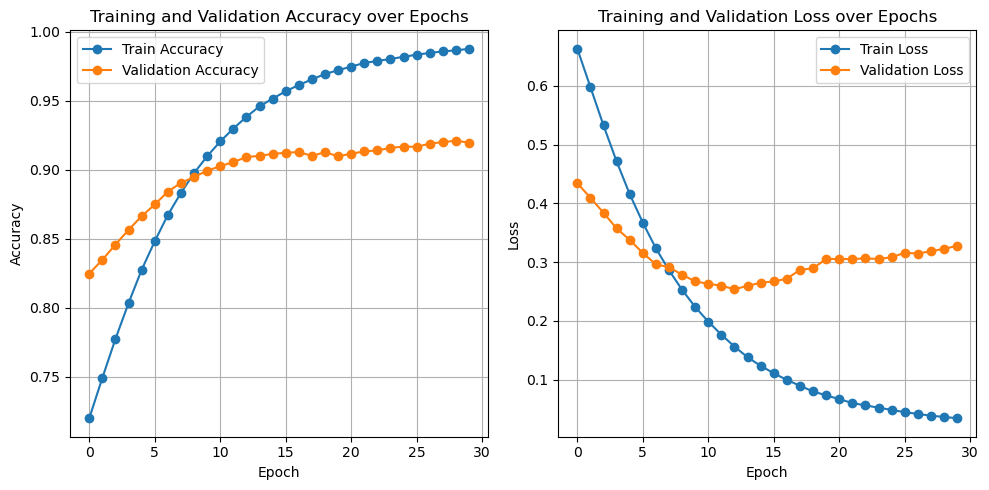

In [227]:
test_model_accuracy(model)

## Adding Dropout Layers

In [228]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_144 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_36 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_3 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 simple_rnn_145 (SimpleRNN)  (None, 5, 32)             3104      
                                                                 
 batch_normalization_37 (Bat  (None, 5, 32)          

In [229]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 10s 35ms/step - loss: 0.9235 - accuracy: 0.5399 - val_loss: 0.6056 - val_accuracy: 0.7709
Epoch 2/30
175/175 [==============================] - 2s 14ms/step - loss: 0.6404 - accuracy: 0.7500 - val_loss: 0.4533 - val_accuracy: 0.8192
Epoch 3/30
175/175 [==============================] - 2s 11ms/step - loss: 0.5085 - accuracy: 0.8147 - val_loss: 0.3464 - val_accuracy: 0.8674
Epoch 4/30
175/175 [==============================] - 2s 13ms/step - loss: 0.4424 - accuracy: 0.8410 - val_loss: 0.3207 - val_accuracy: 0.8731
Epoch 5/30
175/175 [==============================] - 2s 9ms/step - loss: 0.3993 - accuracy: 0.8501 - val_loss: 0.2953 - val_accuracy: 0.8817
Epoch 6/30
175/175 [==============================] - 2s 12ms/step - loss: 0.3782 - accuracy: 0.8644 - val_loss: 0.2956 - val_accuracy: 0.8835
Epoch 7/30
175/175 [==============================] - 2s 11ms/step - loss: 0.3487 - accuracy: 0.8765 - val_loss: 0.2594 - val_accuracy: 0.8960

110/110 [==============================] - 0s 3ms/step - loss: 0.2728 - accuracy: 0.9239
Test Accuracy: 92.3935%


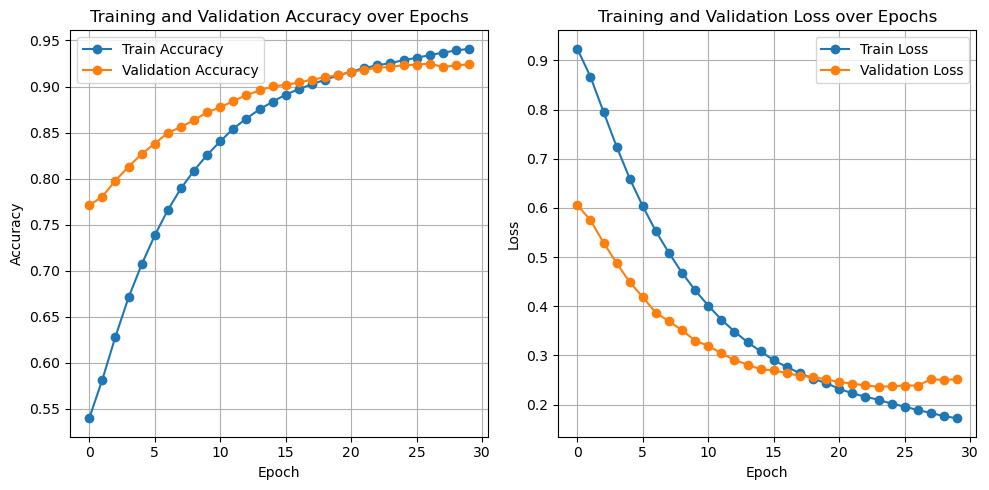

In [230]:
test_model_accuracy(model)

## Complex Architecture
### Tested with Average Pooling Layers (Best Perfomance)

In [231]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_146 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_38 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_147 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_39 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_4 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                     

In [232]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 22s 68ms/step - loss: 0.9343 - accuracy: 0.5327 - val_loss: 0.6471 - val_accuracy: 0.7202
Epoch 2/30
175/175 [==============================] - 3s 18ms/step - loss: 0.6308 - accuracy: 0.7308 - val_loss: 0.4033 - val_accuracy: 0.8617
Epoch 3/30
175/175 [==============================] - 3s 20ms/step - loss: 0.4988 - accuracy: 0.8092 - val_loss: 0.3408 - val_accuracy: 0.8746
Epoch 4/30
175/175 [==============================] - 3s 20ms/step - loss: 0.4187 - accuracy: 0.8466 - val_loss: 0.3018 - val_accuracy: 0.8860
Epoch 5/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3730 - accuracy: 0.8658 - val_loss: 0.2836 - val_accuracy: 0.8949
Epoch 6/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3386 - accuracy: 0.8772 - val_loss: 0.2586 - val_accuracy: 0.9017
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3092 - accuracy: 0.8931 - val_loss: 0.2478 - val_accuracy: 0.907

110/110 [==============================] - 1s 5ms/step - loss: 0.1991 - accuracy: 0.9391
Test Accuracy: 93.9091%


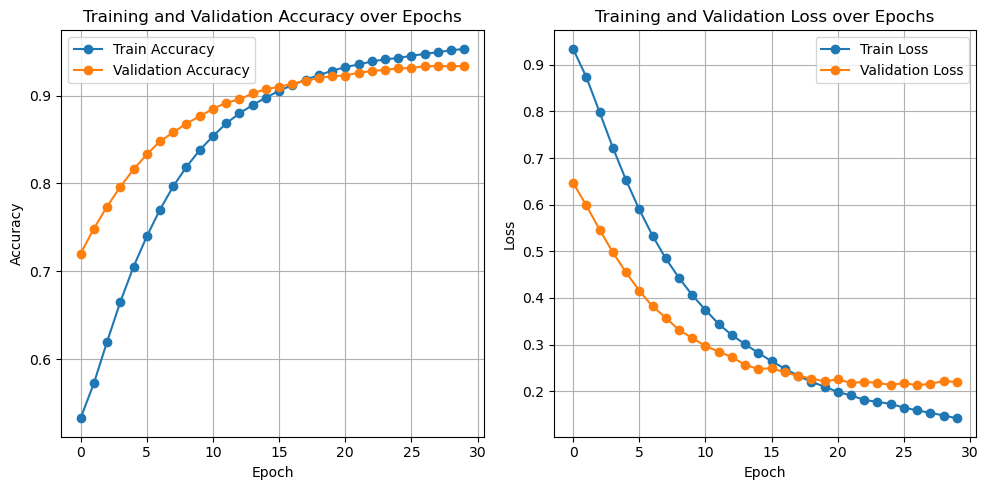

In [233]:
test_model_accuracy(model)

### Tested with Max Pooling Layers

In [237]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalMaxPooling1D, TimeDistributed, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_156 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_48 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_157 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_49 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                     

In [238]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 23ms/step - loss: 1.0346 - accuracy: 0.4500 - val_loss: 0.7580 - val_accuracy: 0.7048
Epoch 2/30
175/175 [==============================] - 3s 18ms/step - loss: 0.7543 - accuracy: 0.6781 - val_loss: 0.4906 - val_accuracy: 0.8181
Epoch 3/30
175/175 [==============================] - 3s 17ms/step - loss: 0.5758 - accuracy: 0.7795 - val_loss: 0.4575 - val_accuracy: 0.8320
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4868 - accuracy: 0.8202 - val_loss: 0.3807 - val_accuracy: 0.8485
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4496 - accuracy: 0.8393 - val_loss: 0.3757 - val_accuracy: 0.8606
Epoch 6/30
175/175 [==============================] - 3s 16ms/step - loss: 0.4263 - accuracy: 0.8454 - val_loss: 0.3212 - val_accuracy: 0.8721
Epoch 7/30
175/175 [==============================] - 3s 18ms/step - loss: 0.3882 - accuracy: 0.8601 - val_loss: 0.3466 - val_accuracy: 0.8763

110/110 [==============================] - 1s 6ms/step - loss: 0.2543 - accuracy: 0.9231
Test Accuracy: 92.3077%


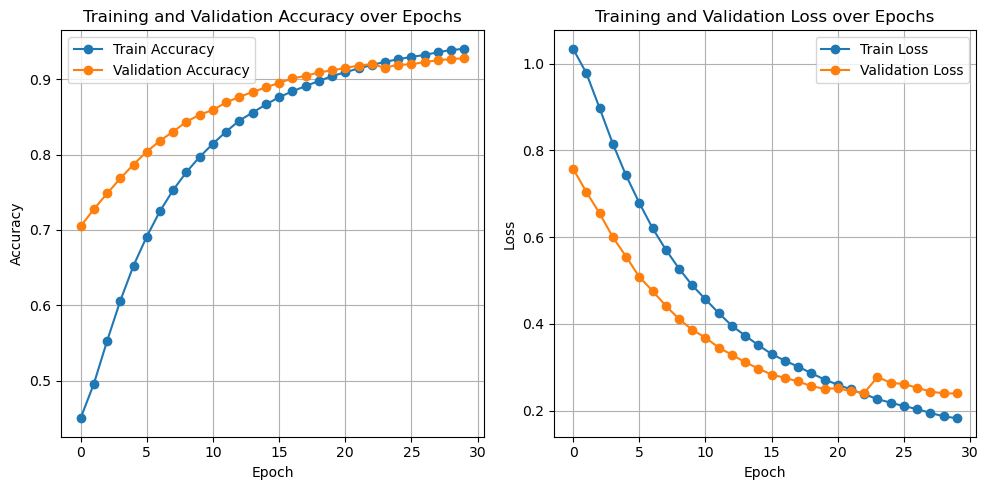

In [239]:
test_model_accuracy(model)

## More Complex Arhitecture

In [234]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_150 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_42 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_151 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_43 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_152 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_44 (Bat  (None, 11, 64)         

In [235]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 34ms/step - loss: 0.8838 - accuracy: 0.5628 - val_loss: 0.6677 - val_accuracy: 0.7069
Epoch 2/30
175/175 [==============================] - 4s 25ms/step - loss: 0.5994 - accuracy: 0.7744 - val_loss: 0.4295 - val_accuracy: 0.8406
Epoch 3/30
175/175 [==============================] - 4s 24ms/step - loss: 0.4597 - accuracy: 0.8357 - val_loss: 0.3472 - val_accuracy: 0.8670
Epoch 4/30
175/175 [==============================] - 4s 23ms/step - loss: 0.3907 - accuracy: 0.8625 - val_loss: 0.2855 - val_accuracy: 0.8867
Epoch 5/30
175/175 [==============================] - 4s 25ms/step - loss: 0.3634 - accuracy: 0.8752 - val_loss: 0.3176 - val_accuracy: 0.8781
Epoch 6/30
175/175 [==============================] - 4s 23ms/step - loss: 0.3226 - accuracy: 0.8879 - val_loss: 0.2575 - val_accuracy: 0.8978
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.2954 - accuracy: 0.8981 - val_loss: 0.2572 - val_accuracy: 0.910

110/110 [==============================] - 1s 6ms/step - loss: 0.2532 - accuracy: 0.9317
Test Accuracy: 93.1656%


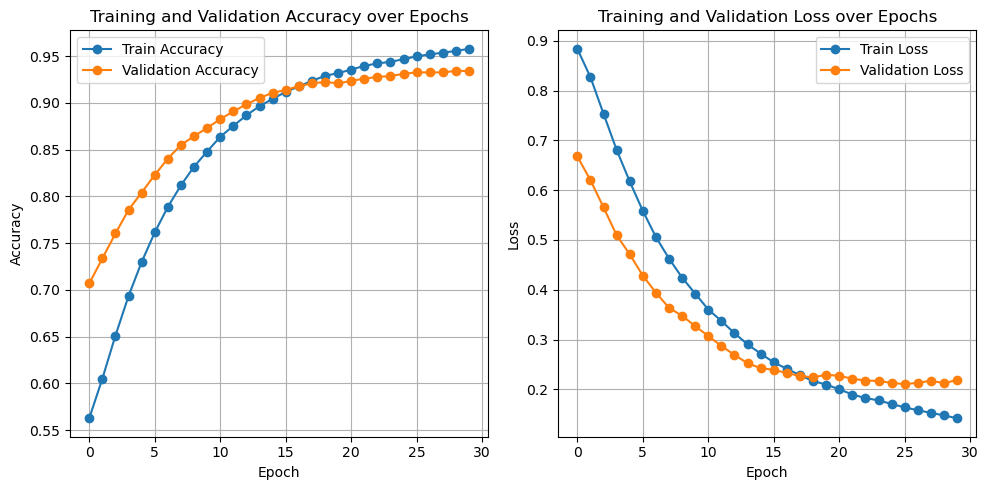

In [236]:
test_model_accuracy(model)

## Different Approach

In [240]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),

    SimpleRNN(16, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(16, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_160 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_52 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_161 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_53 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_6 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                     

In [241]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 27ms/step - loss: 0.9446 - accuracy: 0.5306 - val_loss: 0.6025 - val_accuracy: 0.7898
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.6146 - accuracy: 0.7598 - val_loss: 0.4020 - val_accuracy: 0.8463
Epoch 3/30
175/175 [==============================] - 3s 20ms/step - loss: 0.4870 - accuracy: 0.8191 - val_loss: 0.3685 - val_accuracy: 0.8706
Epoch 4/30
175/175 [==============================] - 4s 21ms/step - loss: 0.4323 - accuracy: 0.8413 - val_loss: 0.3319 - val_accuracy: 0.8753
Epoch 5/30
175/175 [==============================] - 4s 20ms/step - loss: 0.3901 - accuracy: 0.8624 - val_loss: 0.2978 - val_accuracy: 0.8914
Epoch 6/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3521 - accuracy: 0.8786 - val_loss: 0.3281 - val_accuracy: 0.8781
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3435 - accuracy: 0.8792 - val_loss: 0.2826 - val_accuracy: 0.894

110/110 [==============================] - 1s 7ms/step - loss: 0.2750 - accuracy: 0.9254
Test Accuracy: 92.5365%


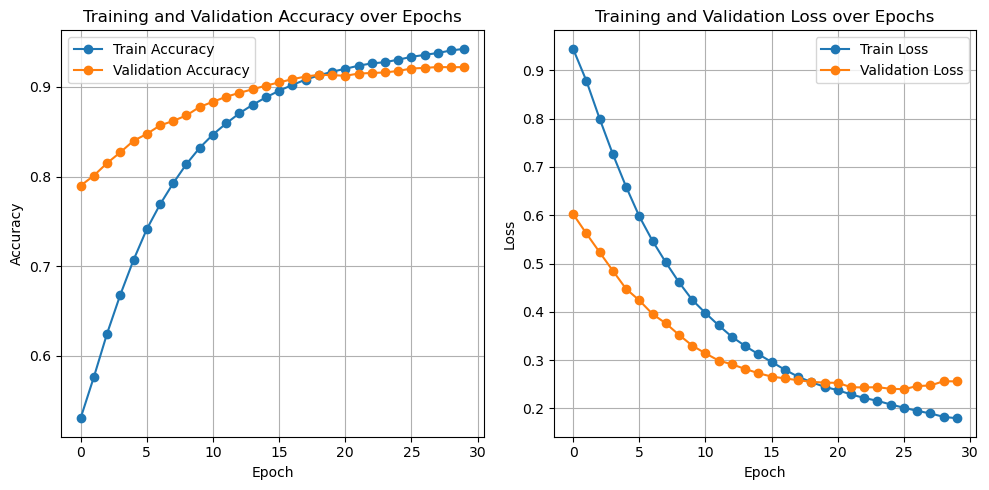

In [242]:
test_model_accuracy(model)

## Changing the RNNs Specifics
### All activations Functions Tested with Relu instead of Tanh

In [243]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='relu', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='relu', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_166 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_58 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_167 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_59 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_9 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                     

In [244]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 23ms/step - loss: 0.8208 - accuracy: 0.6055 - val_loss: 0.4369 - val_accuracy: 0.8531
Epoch 2/30
175/175 [==============================] - 3s 18ms/step - loss: 0.5054 - accuracy: 0.8201 - val_loss: 0.3200 - val_accuracy: 0.8871
Epoch 3/30
175/175 [==============================] - 4s 21ms/step - loss: 0.4131 - accuracy: 0.8536 - val_loss: 0.3130 - val_accuracy: 0.8867
Epoch 4/30
175/175 [==============================] - 3s 20ms/step - loss: 0.3549 - accuracy: 0.8688 - val_loss: 0.3119 - val_accuracy: 0.8831
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.3147 - accuracy: 0.8897 - val_loss: 0.2680 - val_accuracy: 0.9028
Epoch 6/30
175/175 [==============================] - 3s 18ms/step - loss: 0.2913 - accuracy: 0.8987 - val_loss: 0.2473 - val_accuracy: 0.9103
Epoch 7/30
175/175 [==============================] - 3s 18ms/step - loss: 0.2596 - accuracy: 0.9138 - val_loss: 0.2011 - val_accuracy: 0.9267

110/110 [==============================] - 1s 5ms/step - loss: 0.2674 - accuracy: 0.9262
Test Accuracy: 92.6223%


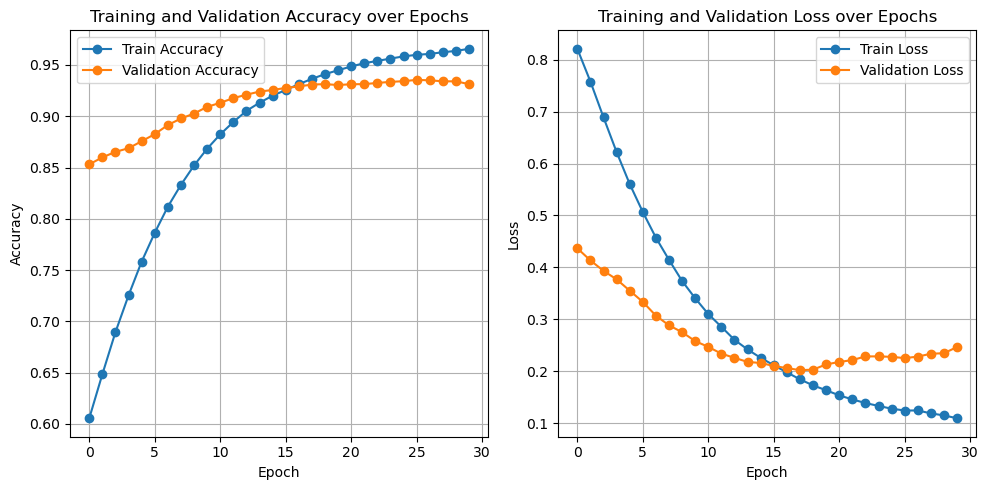

In [245]:
test_model_accuracy(model)

## Changing the RNNs Specifics
### All activations Functions Tested with linear instead of Tanh

In [246]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='linear', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='linear', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='linear', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='linear', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_170 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_62 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_171 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_63 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_10 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [247]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 22ms/step - loss: 0.8349 - accuracy: 0.6061 - val_loss: 0.4865 - val_accuracy: 0.8270
Epoch 2/30
175/175 [==============================] - 3s 20ms/step - loss: 0.6034 - accuracy: 0.7708 - val_loss: 0.3969 - val_accuracy: 0.8553
Epoch 3/30
175/175 [==============================] - 3s 20ms/step - loss: 0.5168 - accuracy: 0.8096 - val_loss: 0.3776 - val_accuracy: 0.8631
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4564 - accuracy: 0.8408 - val_loss: 0.3282 - val_accuracy: 0.8921
Epoch 5/30
175/175 [==============================] - 3s 20ms/step - loss: 0.4176 - accuracy: 0.8553 - val_loss: 0.2936 - val_accuracy: 0.9010
Epoch 6/30
175/175 [==============================] - 3s 20ms/step - loss: 0.3955 - accuracy: 0.8622 - val_loss: 0.2729 - val_accuracy: 0.9099
Epoch 7/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3644 - accuracy: 0.8764 - val_loss: 0.2476 - val_accuracy: 0.9157

110/110 [==============================] - 1s 6ms/step - loss: 0.2255 - accuracy: 0.9214
Test Accuracy: 92.1361%


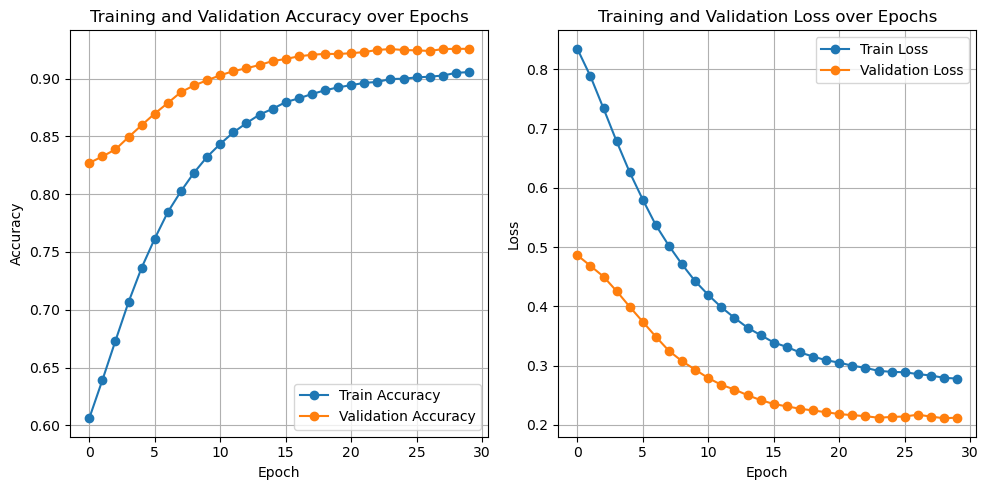

In [248]:
test_model_accuracy(model)

## Changing the RNNs Specifics
### All activations Functions Tested with Sigmoid instead of Tanh

In [252]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='sigmoid', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='sigmoid', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='sigmoid', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='sigmoid', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_178 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_70 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_179 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_71 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_12 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [253]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 23ms/step - loss: 0.8369 - accuracy: 0.6244 - val_loss: 1.0968 - val_accuracy: 0.3206
Epoch 2/30
175/175 [==============================] - 3s 18ms/step - loss: 0.5785 - accuracy: 0.8071 - val_loss: 0.4448 - val_accuracy: 0.8642
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4750 - accuracy: 0.8358 - val_loss: 0.3699 - val_accuracy: 0.8670
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4239 - accuracy: 0.8502 - val_loss: 0.3455 - val_accuracy: 0.8681
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3866 - accuracy: 0.8662 - val_loss: 0.3187 - val_accuracy: 0.8874
Epoch 6/30
175/175 [==============================] - 3s 18ms/step - loss: 0.3606 - accuracy: 0.8725 - val_loss: 0.3247 - val_accuracy: 0.8788
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3460 - accuracy: 0.8771 - val_loss: 0.2949 - val_accuracy: 0.8964

110/110 [==============================] - 1s 6ms/step - loss: 0.2127 - accuracy: 0.9337
Test Accuracy: 93.3657%


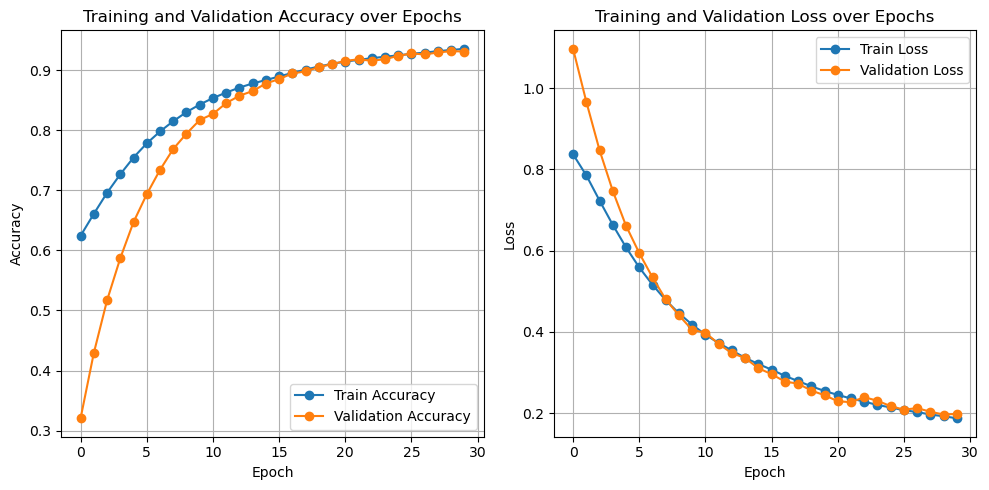

In [254]:
test_model_accuracy(model)

## Changing Learning Rate and Optimizers
### Changing The Learning Rate 0.002

In [255]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_182 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_74 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_183 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_75 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_13 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [256]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 22s 75ms/step - loss: 0.8839 - accuracy: 0.5676 - val_loss: 0.5385 - val_accuracy: 0.8016
Epoch 2/30
175/175 [==============================] - 3s 20ms/step - loss: 0.5230 - accuracy: 0.8096 - val_loss: 0.3721 - val_accuracy: 0.8592
Epoch 3/30
175/175 [==============================] - 3s 20ms/step - loss: 0.4185 - accuracy: 0.8442 - val_loss: 0.2931 - val_accuracy: 0.8903
Epoch 4/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3683 - accuracy: 0.8681 - val_loss: 0.2911 - val_accuracy: 0.8892
Epoch 5/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3327 - accuracy: 0.8854 - val_loss: 0.2442 - val_accuracy: 0.9096
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3003 - accuracy: 0.8954 - val_loss: 0.2273 - val_accuracy: 0.9203
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.2785 - accuracy: 0.9055 - val_loss: 0.2423 - val_accuracy: 0.913

110/110 [==============================] - 1s 5ms/step - loss: 0.2235 - accuracy: 0.9319
Test Accuracy: 93.1942%


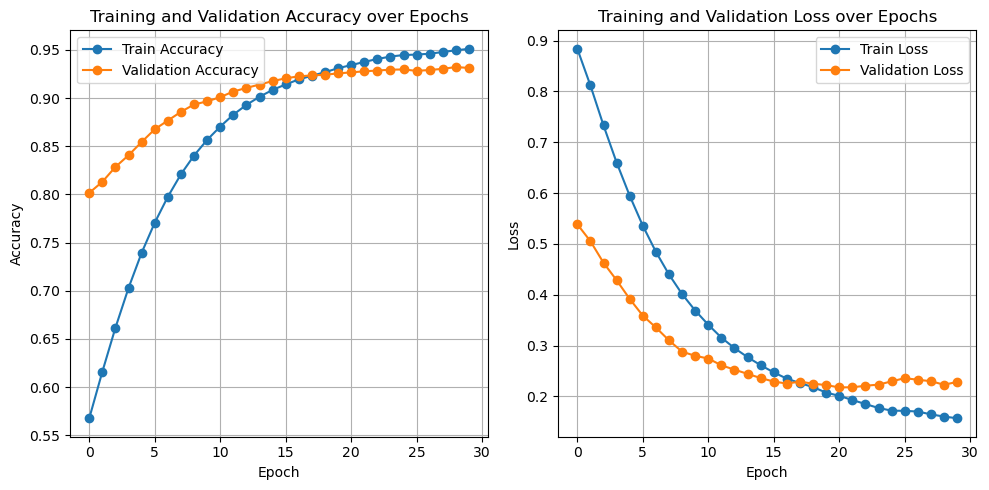

In [257]:
test_model_accuracy(model)

### Changing The Learning Rate 0.0005

In [258]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_186 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_78 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_187 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_79 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_14 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [259]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 24ms/step - loss: 0.9881 - accuracy: 0.4797 - val_loss: 0.7499 - val_accuracy: 0.7337
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.7348 - accuracy: 0.6894 - val_loss: 0.4739 - val_accuracy: 0.8317
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.5828 - accuracy: 0.7801 - val_loss: 0.4022 - val_accuracy: 0.8463
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.5055 - accuracy: 0.8191 - val_loss: 0.3482 - val_accuracy: 0.8649
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4474 - accuracy: 0.8378 - val_loss: 0.3234 - val_accuracy: 0.8717
Epoch 6/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4206 - accuracy: 0.8502 - val_loss: 0.3141 - val_accuracy: 0.8756
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3850 - accuracy: 0.8633 - val_loss: 0.2978 - val_accuracy: 0.8885

110/110 [==============================] - 1s 5ms/step - loss: 0.2530 - accuracy: 0.9225
Test Accuracy: 92.2505%


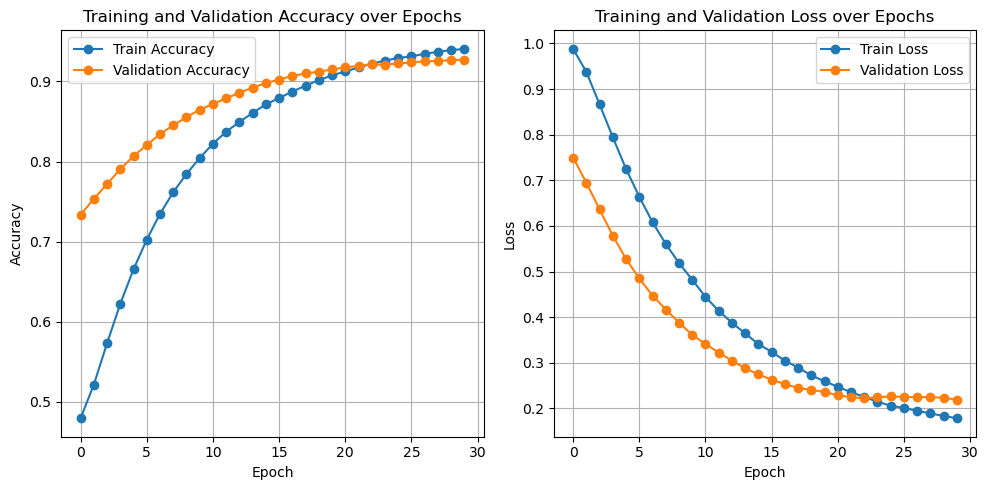

In [260]:
test_model_accuracy(model)

### Changing The Learning Rate 0.0001

In [261]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_190 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_82 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_191 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_83 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_15 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [262]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 21ms/step - loss: 1.1003 - accuracy: 0.3911 - val_loss: 1.0018 - val_accuracy: 0.5132
Epoch 2/30
175/175 [==============================] - 3s 16ms/step - loss: 1.0351 - accuracy: 0.4428 - val_loss: 0.9243 - val_accuracy: 0.6101
Epoch 3/30
175/175 [==============================] - 3s 17ms/step - loss: 0.9813 - accuracy: 0.4979 - val_loss: 0.8471 - val_accuracy: 0.6959
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.9142 - accuracy: 0.5524 - val_loss: 0.7642 - val_accuracy: 0.7398
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.8529 - accuracy: 0.5887 - val_loss: 0.6839 - val_accuracy: 0.7620
Epoch 6/30
175/175 [==============================] - 3s 17ms/step - loss: 0.8017 - accuracy: 0.6276 - val_loss: 0.6159 - val_accuracy: 0.7773
Epoch 7/30
175/175 [==============================] - 3s 16ms/step - loss: 0.7423 - accuracy: 0.6641 - val_loss: 0.5608 - val_accuracy: 0.7977

110/110 [==============================] - 1s 7ms/step - loss: 0.3280 - accuracy: 0.8727
Test Accuracy: 87.2748%


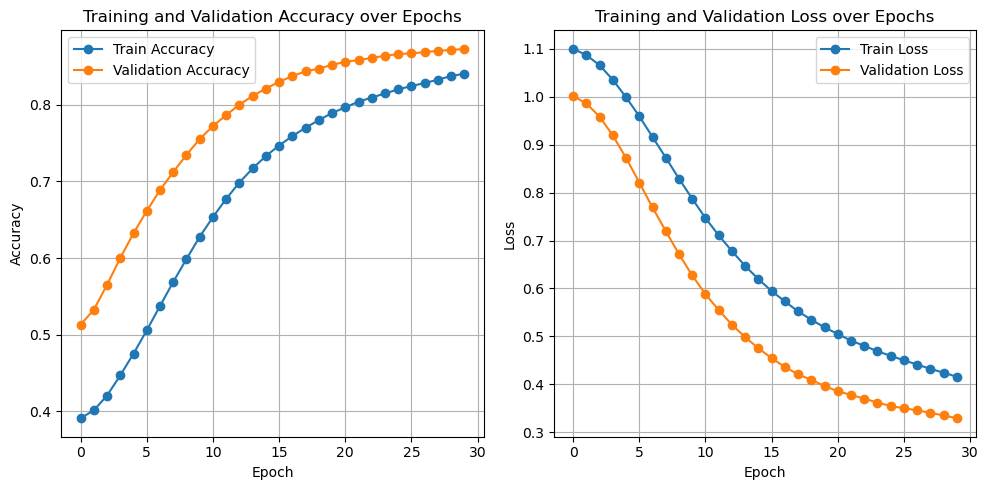

In [263]:
test_model_accuracy(model)

### Changing The Learning Rate 0.00075

In [264]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00075),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_194 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_86 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_195 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_87 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_16 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [265]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 23s 74ms/step - loss: 0.9502 - accuracy: 0.5256 - val_loss: 0.6132 - val_accuracy: 0.7956
Epoch 2/30
175/175 [==============================] - 3s 18ms/step - loss: 0.6203 - accuracy: 0.7511 - val_loss: 0.4295 - val_accuracy: 0.8370
Epoch 3/30
175/175 [==============================] - 3s 17ms/step - loss: 0.4909 - accuracy: 0.8169 - val_loss: 0.4061 - val_accuracy: 0.8474
Epoch 4/30
175/175 [==============================] - 3s 17ms/step - loss: 0.4366 - accuracy: 0.8440 - val_loss: 0.3271 - val_accuracy: 0.8785
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4091 - accuracy: 0.8586 - val_loss: 0.3066 - val_accuracy: 0.8849
Epoch 6/30
175/175 [==============================] - 3s 17ms/step - loss: 0.3643 - accuracy: 0.8726 - val_loss: 0.3003 - val_accuracy: 0.8924
Epoch 7/30
175/175 [==============================] - 3s 18ms/step - loss: 0.3328 - accuracy: 0.8895 - val_loss: 0.2933 - val_accuracy: 0.897

110/110 [==============================] - 1s 5ms/step - loss: 0.2525 - accuracy: 0.9305
Test Accuracy: 93.0512%


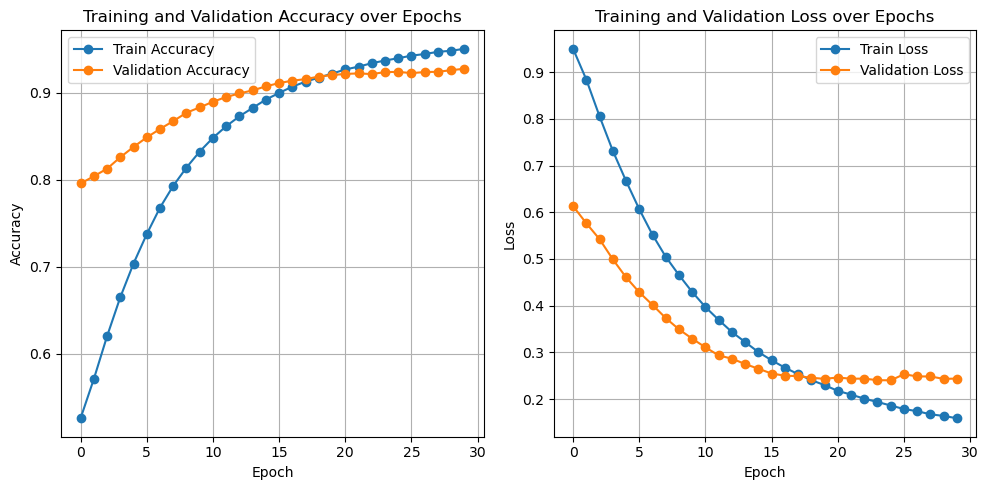

In [266]:
test_model_accuracy(model)

### Changing the Learning Rate to 0.000865

In [267]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000865),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_198 (SimpleRNN)  (None, 11, 64)            8064      
                                                                 
 batch_normalization_90 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_199 (SimpleRNN)  (None, 11, 64)            8256      
                                                                 
 batch_normalization_91 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_17 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [268]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 23ms/step - loss: 0.9249 - accuracy: 0.5408 - val_loss: 0.6072 - val_accuracy: 0.7877
Epoch 2/30
175/175 [==============================] - 3s 18ms/step - loss: 0.5943 - accuracy: 0.7814 - val_loss: 0.3765 - val_accuracy: 0.8617
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4634 - accuracy: 0.8413 - val_loss: 0.3539 - val_accuracy: 0.8595
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.4064 - accuracy: 0.8624 - val_loss: 0.3132 - val_accuracy: 0.8846
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.3686 - accuracy: 0.8800 - val_loss: 0.2735 - val_accuracy: 0.8981
Epoch 6/30
175/175 [==============================] - 3s 17ms/step - loss: 0.3440 - accuracy: 0.8845 - val_loss: 0.2580 - val_accuracy: 0.8996
Epoch 7/30
175/175 [==============================] - 3s 17ms/step - loss: 0.3038 - accuracy: 0.8973 - val_loss: 0.2596 - val_accuracy: 0.9046

110/110 [==============================] - 1s 6ms/step - loss: 0.2363 - accuracy: 0.9319
Test Accuracy: 93.1942%


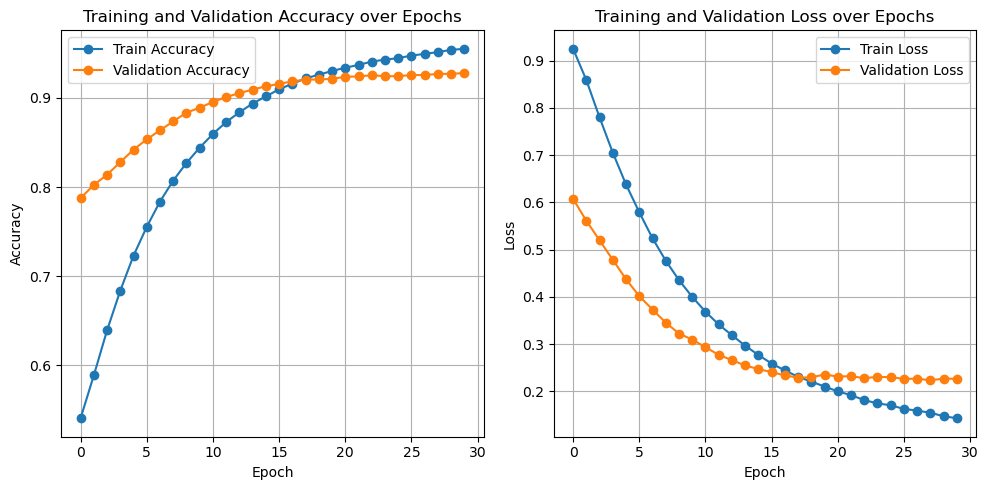

In [269]:
test_model_accuracy(model)

### Changing the Learning Rate to 0.00015

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_12 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_13 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_3 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [21]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 16s 29ms/step - loss: 0.8408 - accuracy: 0.6114 - val_loss: 0.5306 - val_accuracy: 0.7988
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.5531 - accuracy: 0.7886 - val_loss: 0.4083 - val_accuracy: 0.8410
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4510 - accuracy: 0.8367 - val_loss: 0.3486 - val_accuracy: 0.8710
Epoch 4/30
175/175 [==============================] - 4s 21ms/step - loss: 0.4011 - accuracy: 0.8571 - val_loss: 0.3142 - val_accuracy: 0.8888
Epoch 5/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3624 - accuracy: 0.8736 - val_loss: 0.2467 - val_accuracy: 0.9092
Epoch 6/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3280 - accuracy: 0.8878 - val_loss: 0.2255 - val_accuracy: 0.9117
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.2836 - accuracy: 0.9026 - val_loss: 0.2276 - val_accuracy: 0.912

110/110 [==============================] - 1s 8ms/step - loss: 0.2662 - accuracy: 0.9285
Test Accuracy: 92.8510%


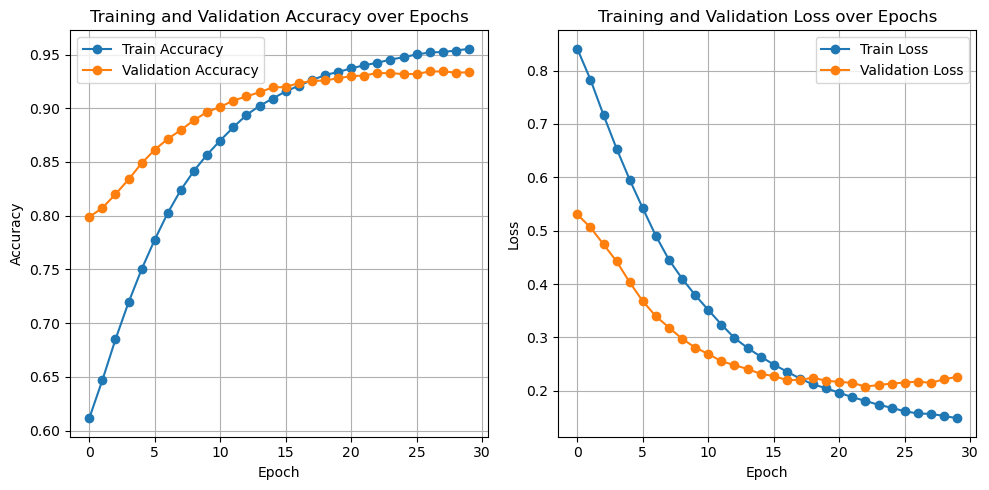

In [22]:
test_model_accuracy(model)

### Changing the Learning Rate to 0.00025

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0025),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_20 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_21 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_5 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [27]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 32ms/step - loss: 0.7650 - accuracy: 0.6635 - val_loss: 0.4595 - val_accuracy: 0.8352
Epoch 2/30
175/175 [==============================] - 4s 20ms/step - loss: 0.4799 - accuracy: 0.8308 - val_loss: 0.3879 - val_accuracy: 0.8638
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4052 - accuracy: 0.8592 - val_loss: 0.3176 - val_accuracy: 0.8771
Epoch 4/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3330 - accuracy: 0.8862 - val_loss: 0.2775 - val_accuracy: 0.8942
Epoch 5/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3275 - accuracy: 0.8927 - val_loss: 0.2723 - val_accuracy: 0.9028
Epoch 6/30
175/175 [==============================] - 4s 22ms/step - loss: 0.2840 - accuracy: 0.9077 - val_loss: 0.2270 - val_accuracy: 0.9185
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.2685 - accuracy: 0.9125 - val_loss: 0.2069 - val_accuracy: 0.926

110/110 [==============================] - 1s 6ms/step - loss: 0.2245 - accuracy: 0.9328
Test Accuracy: 93.2800%


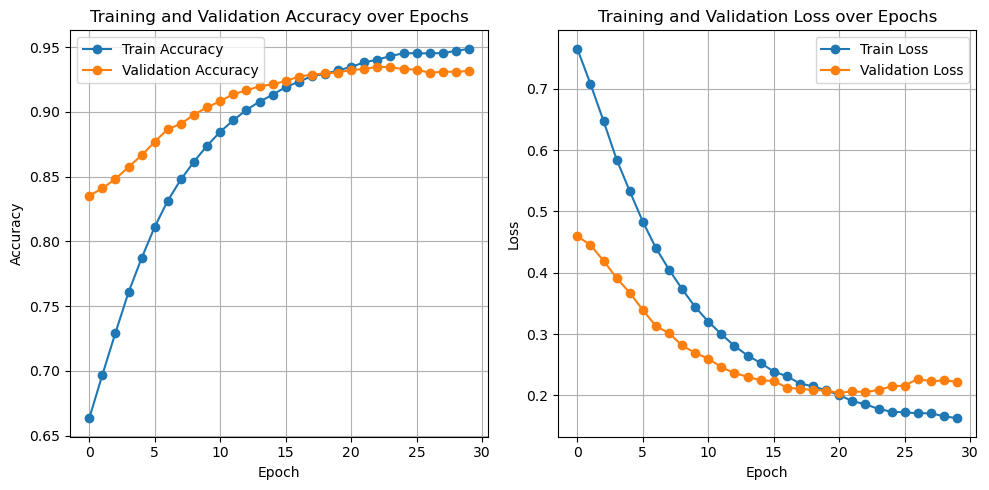

In [28]:
test_model_accuracy(model)

### Changing the Epsilon Value 1.1e-07

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=1.1e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 11, 64)            8064      
                                                                 
 batch_normalization_4 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 11, 64)            8256      
                                                                 
 batch_normalization_5 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 average_pooling1d_1 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [14]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 31ms/step - loss: 0.8435 - accuracy: 0.5962 - val_loss: 0.5382 - val_accuracy: 0.8016
Epoch 2/30
175/175 [==============================] - 4s 23ms/step - loss: 0.5771 - accuracy: 0.7836 - val_loss: 0.4184 - val_accuracy: 0.8460
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.4775 - accuracy: 0.8264 - val_loss: 0.3570 - val_accuracy: 0.8760
Epoch 4/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4141 - accuracy: 0.8555 - val_loss: 0.3090 - val_accuracy: 0.8910
Epoch 5/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3816 - accuracy: 0.8681 - val_loss: 0.2912 - val_accuracy: 0.8914
Epoch 6/30
175/175 [==============================] - 4s 23ms/step - loss: 0.3434 - accuracy: 0.8802 - val_loss: 0.2741 - val_accuracy: 0.9046
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3217 - accuracy: 0.8878 - val_loss: 0.2739 - val_accuracy: 0.901

110/110 [==============================] - 1s 8ms/step - loss: 0.2457 - accuracy: 0.9322
Test Accuracy: 93.2228%


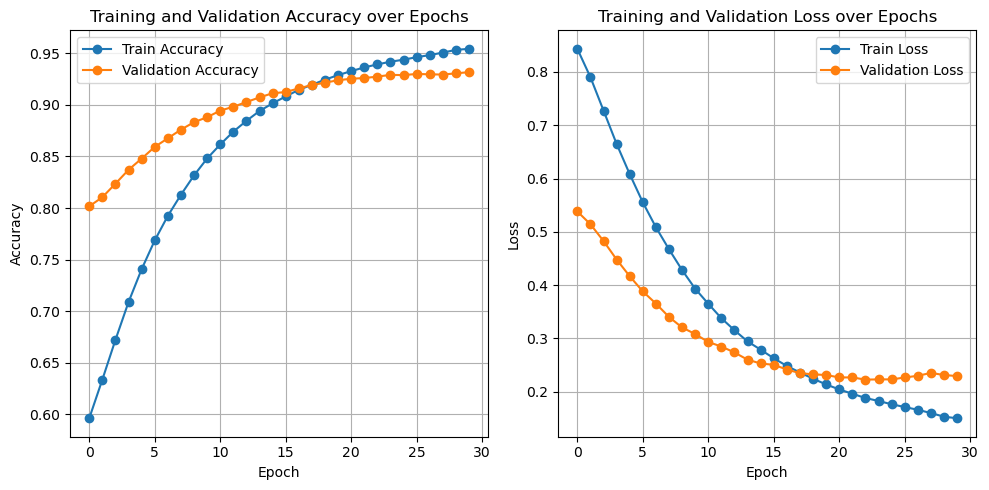

In [15]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.8e-07

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.8e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 11, 64)            8064      
                                                                 
 batch_normalization_8 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 11, 64)            8256      
                                                                 
 batch_normalization_9 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 average_pooling1d_2 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [18]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 90s 38ms/step - loss: 0.8872 - accuracy: 0.5617 - val_loss: 0.6089 - val_accuracy: 0.7605
Epoch 2/30
175/175 [==============================] - 4s 22ms/step - loss: 0.6523 - accuracy: 0.7449 - val_loss: 0.4287 - val_accuracy: 0.8452
Epoch 3/30
175/175 [==============================] - 4s 22ms/step - loss: 0.5153 - accuracy: 0.8178 - val_loss: 0.3691 - val_accuracy: 0.8685
Epoch 4/30
175/175 [==============================] - 3s 20ms/step - loss: 0.4253 - accuracy: 0.8517 - val_loss: 0.3307 - val_accuracy: 0.8863
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3792 - accuracy: 0.8669 - val_loss: 0.3037 - val_accuracy: 0.8906
Epoch 6/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3391 - accuracy: 0.8866 - val_loss: 0.2603 - val_accuracy: 0.9053
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.3079 - accuracy: 0.8945 - val_loss: 0.2491 - val_accuracy: 0.906

110/110 [==============================] - 2s 14ms/step - loss: 0.2704 - accuracy: 0.9328
Test Accuracy: 93.2800%


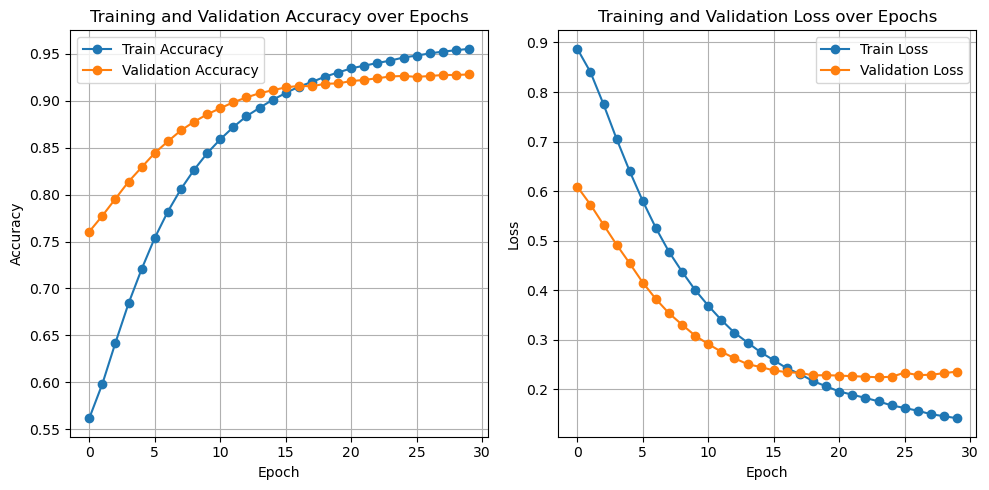

In [19]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.9e-07

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.9e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_24 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_25 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_6 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [32]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 13s 26ms/step - loss: 0.9198 - accuracy: 0.5290 - val_loss: 0.6775 - val_accuracy: 0.7891
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.6204 - accuracy: 0.7482 - val_loss: 0.3862 - val_accuracy: 0.8588
Epoch 3/30
175/175 [==============================] - 4s 22ms/step - loss: 0.4701 - accuracy: 0.8181 - val_loss: 0.3260 - val_accuracy: 0.8692
Epoch 4/30
175/175 [==============================] - 4s 22ms/step - loss: 0.4217 - accuracy: 0.8417 - val_loss: 0.2998 - val_accuracy: 0.8742
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3566 - accuracy: 0.8671 - val_loss: 0.2854 - val_accuracy: 0.8867
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3287 - accuracy: 0.8815 - val_loss: 0.2462 - val_accuracy: 0.9042
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.2946 - accuracy: 0.8964 - val_loss: 0.2533 - val_accuracy: 0.908

110/110 [==============================] - 1s 9ms/step - loss: 0.2538 - accuracy: 0.9288
Test Accuracy: 92.8796%


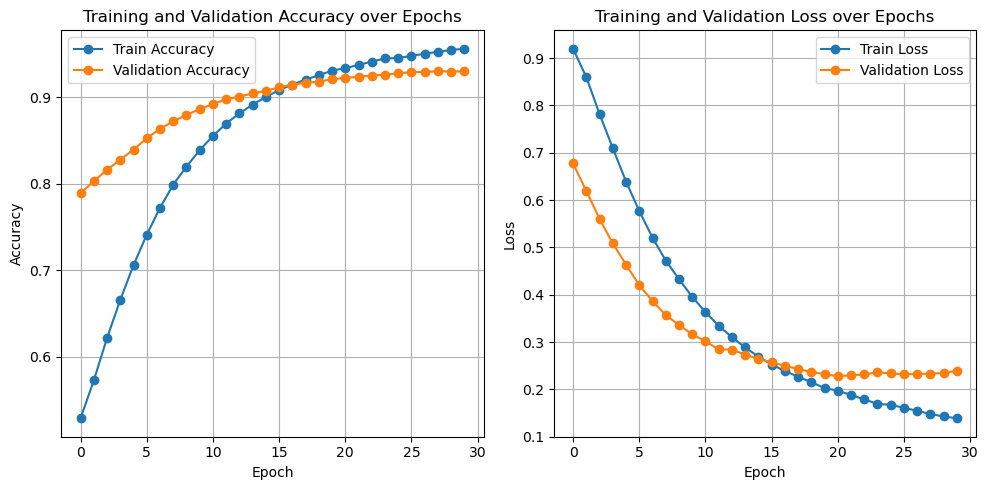

In [33]:
test_model_accuracy(model)

### Changing the Epsilon Value 2e-07

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=2e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_28 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_29 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_7 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [35]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 26ms/step - loss: 0.9248 - accuracy: 0.5450 - val_loss: 0.6318 - val_accuracy: 0.7848
Epoch 2/30
175/175 [==============================] - 4s 22ms/step - loss: 0.6417 - accuracy: 0.7498 - val_loss: 0.3806 - val_accuracy: 0.8595
Epoch 3/30
175/175 [==============================] - 4s 21ms/step - loss: 0.4919 - accuracy: 0.8246 - val_loss: 0.3316 - val_accuracy: 0.8610
Epoch 4/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4198 - accuracy: 0.8515 - val_loss: 0.2941 - val_accuracy: 0.8846
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3719 - accuracy: 0.8701 - val_loss: 0.3217 - val_accuracy: 0.8810
Epoch 6/30
175/175 [==============================] - 4s 22ms/step - loss: 0.3390 - accuracy: 0.8828 - val_loss: 0.2506 - val_accuracy: 0.9089
Epoch 7/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3104 - accuracy: 0.8940 - val_loss: 0.2637 - val_accuracy: 0.901

110/110 [==============================] - 35s 13ms/step - loss: 0.2722 - accuracy: 0.9294
Test Accuracy: 92.9368%


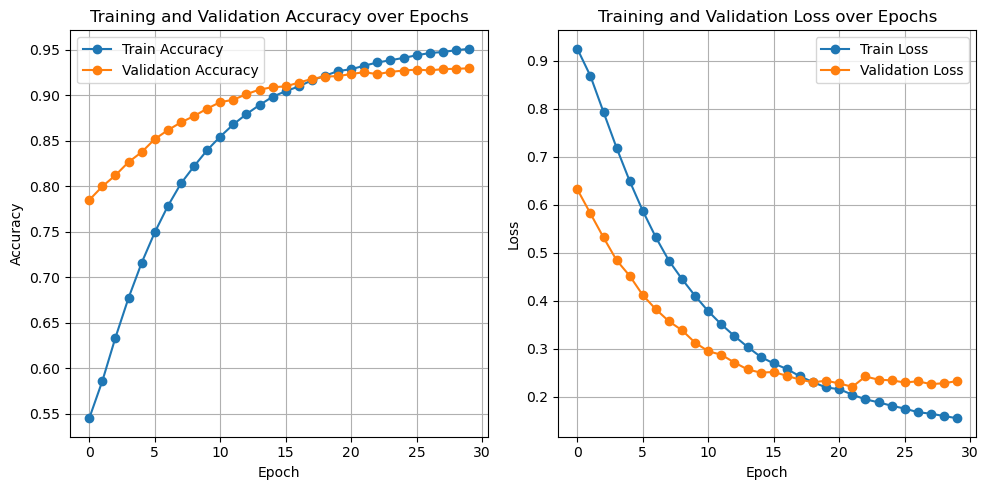

In [36]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.5e-07

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.5e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_32 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_33 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_8 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [38]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 19s 30ms/step - loss: 0.9281 - accuracy: 0.5507 - val_loss: 0.6188 - val_accuracy: 0.7709
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.6179 - accuracy: 0.7661 - val_loss: 0.4308 - val_accuracy: 0.8224
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4835 - accuracy: 0.8251 - val_loss: 0.3376 - val_accuracy: 0.8678
Epoch 4/30
175/175 [==============================] - 4s 21ms/step - loss: 0.4076 - accuracy: 0.8584 - val_loss: 0.3026 - val_accuracy: 0.8863
Epoch 5/30
175/175 [==============================] - 4s 23ms/step - loss: 0.3718 - accuracy: 0.8646 - val_loss: 0.2612 - val_accuracy: 0.9067
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3352 - accuracy: 0.8841 - val_loss: 0.2630 - val_accuracy: 0.9049
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3055 - accuracy: 0.8906 - val_loss: 0.2425 - val_accuracy: 0.914

110/110 [==============================] - 1s 8ms/step - loss: 0.2103 - accuracy: 0.9337
Test Accuracy: 93.3657%


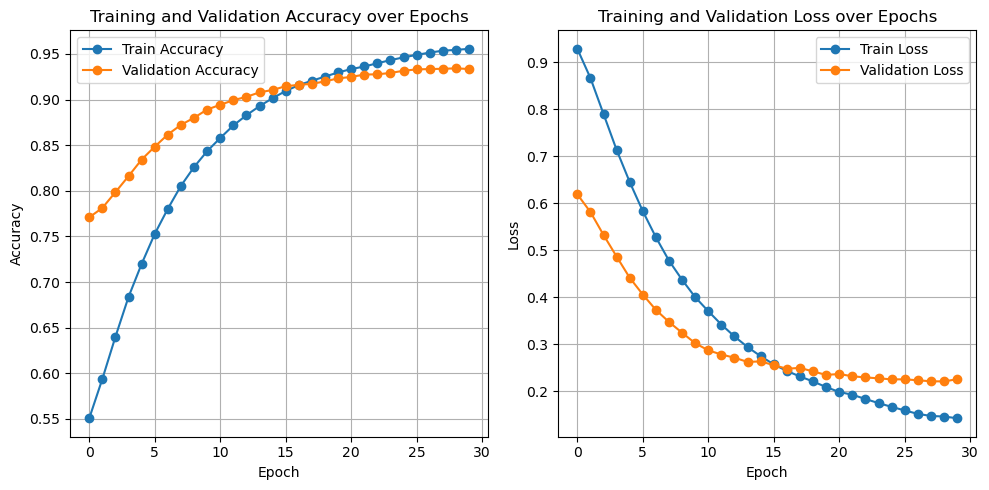

In [39]:
test_model_accuracy(model)

### Changing the Epsilon Value 1e-08

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=1e-08),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_40 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_40 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_41 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_10 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [44]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 13s 27ms/step - loss: 0.8663 - accuracy: 0.5875 - val_loss: 0.6397 - val_accuracy: 0.7445
Epoch 2/30
175/175 [==============================] - 4s 21ms/step - loss: 0.5935 - accuracy: 0.7916 - val_loss: 0.4500 - val_accuracy: 0.8349
Epoch 3/30
175/175 [==============================] - 4s 22ms/step - loss: 0.4666 - accuracy: 0.8314 - val_loss: 0.3655 - val_accuracy: 0.8678
Epoch 4/30
175/175 [==============================] - 4s 24ms/step - loss: 0.4113 - accuracy: 0.8562 - val_loss: 0.3429 - val_accuracy: 0.8728
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3768 - accuracy: 0.8685 - val_loss: 0.3075 - val_accuracy: 0.8871
Epoch 6/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3377 - accuracy: 0.8816 - val_loss: 0.3004 - val_accuracy: 0.8974
Epoch 7/30
175/175 [==============================] - 4s 24ms/step - loss: 0.3289 - accuracy: 0.8876 - val_loss: 0.2941 - val_accuracy: 0.893

110/110 [==============================] - 1s 8ms/step - loss: 0.2321 - accuracy: 0.9337
Test Accuracy: 93.3657%


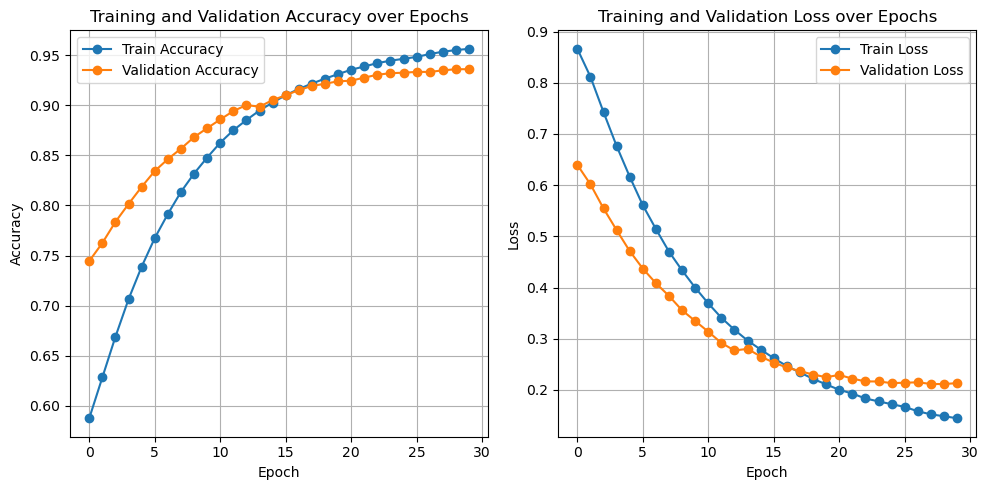

In [45]:
test_model_accuracy(model)

### Changing the Epsilon Value 1e-06

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=1e-06),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_44 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_44 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_45 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_45 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_11 (Avera  (None, 5, 64)            0         
 gePooling1D)                                                    
                                                     

In [47]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 10s 27ms/step - loss: 0.9069 - accuracy: 0.5548 - val_loss: 0.5997 - val_accuracy: 0.7741
Epoch 2/30
175/175 [==============================] - 4s 22ms/step - loss: 0.6028 - accuracy: 0.7697 - val_loss: 0.4023 - val_accuracy: 0.8485
Epoch 3/30
175/175 [==============================] - 4s 22ms/step - loss: 0.4732 - accuracy: 0.8330 - val_loss: 0.3314 - val_accuracy: 0.8713
Epoch 4/30
175/175 [==============================] - 3s 20ms/step - loss: 0.3921 - accuracy: 0.8623 - val_loss: 0.2887 - val_accuracy: 0.8906
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3712 - accuracy: 0.8708 - val_loss: 0.2940 - val_accuracy: 0.8860
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.3155 - accuracy: 0.8853 - val_loss: 0.2569 - val_accuracy: 0.9021
Epoch 7/30
175/175 [==============================] - 4s 25ms/step - loss: 0.2997 - accuracy: 0.8902 - val_loss: 0.2417 - val_accuracy: 0.913

110/110 [==============================] - 1s 8ms/step - loss: 0.2598 - accuracy: 0.9282
Test Accuracy: 92.8224%


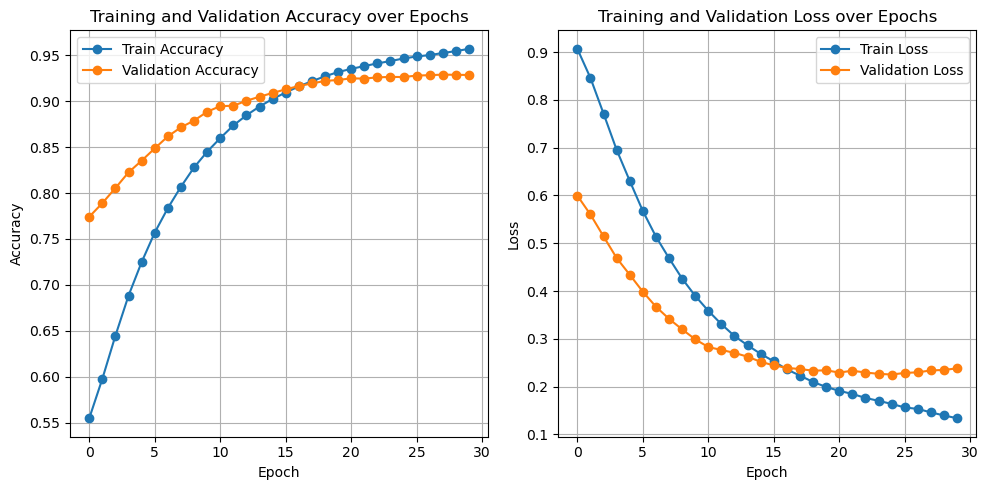

In [48]:
test_model_accuracy(model)

## Testing with SGD Optimizer

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = SGD(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 11, 64)            8064      
                                                                 
 batch_normalization_4 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 11, 64)            8256      
                                                                 
 batch_normalization_5 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 average_pooling1d_1 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [13]:
history = model.fit(x_train_rnn, y_train_rnn, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 29ms/step - loss: 1.0873 - accuracy: 0.3858 - val_loss: 1.0154 - val_accuracy: 0.5340
Epoch 2/30
175/175 [==============================] - 4s 21ms/step - loss: 1.0162 - accuracy: 0.4590 - val_loss: 0.9174 - val_accuracy: 0.5947
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.9394 - accuracy: 0.5373 - val_loss: 0.7966 - val_accuracy: 0.6805
Epoch 4/30
175/175 [==============================] - 3s 19ms/step - loss: 0.8635 - accuracy: 0.6046 - val_loss: 0.6957 - val_accuracy: 0.7395
Epoch 5/30
175/175 [==============================] - 4s 21ms/step - loss: 0.8029 - accuracy: 0.6493 - val_loss: 0.6249 - val_accuracy: 0.7795
Epoch 6/30
175/175 [==============================] - 4s 23ms/step - loss: 0.7549 - accuracy: 0.6859 - val_loss: 0.5767 - val_accuracy: 0.7959
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.7011 - accuracy: 0.7237 - val_loss: 0.5297 - val_accuracy: 0.817

110/110 [==============================] - 1s 8ms/step - loss: 0.3307 - accuracy: 0.8802
Test Accuracy: 88.0183%


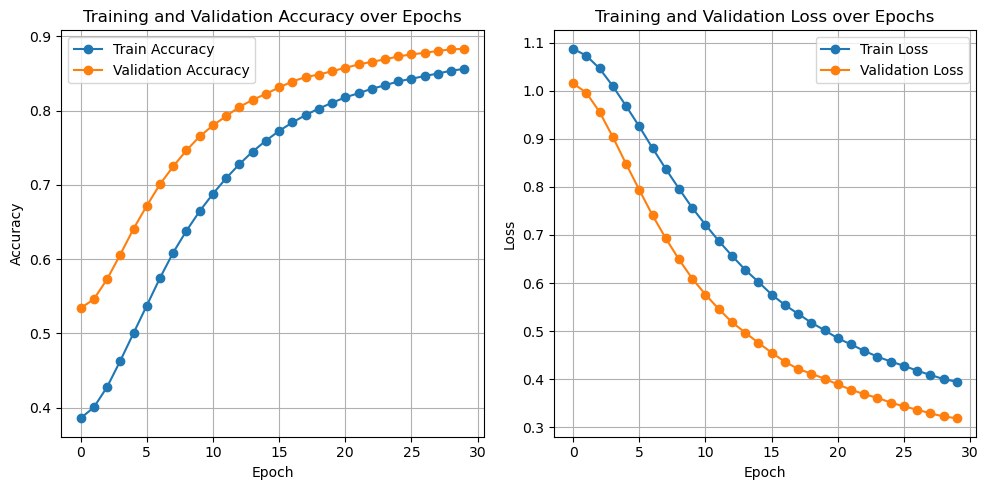

In [14]:
test_model_accuracy(model)

## Implementing Early Stopping

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout

samples, time_steps, features = x_train_rnn.shape
num_classes = y_train_rnn.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 11, 64)            8064      
                                                                 
 batch_normalization_32 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 11, 64)            8256      
                                                                 
 batch_normalization_33 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_8 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  #Monitor validation loss
    patience=5,          #Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,      #Minimum change to qualify as an improvement
    mode='min',          #The training will stop when the quantity monitored stops decreasing
    verbose=1            #Print messages when early stopping is triggered
)

# Testing with high number of epochs
history = model.fit(x_train_rnn, y_train_rnn, epochs=50, validation_split=0.2,batch_size=64, callbacks=[early_stopping])

Epoch 1/50
175/175 [==============================] - 11s 28ms/step - loss: 0.8924 - accuracy: 0.5712 - val_loss: 0.5730 - val_accuracy: 0.8031
Epoch 2/50
175/175 [==============================] - 4s 24ms/step - loss: 0.6047 - accuracy: 0.7683 - val_loss: 0.3857 - val_accuracy: 0.8535
Epoch 3/50
175/175 [==============================] - 4s 24ms/step - loss: 0.4847 - accuracy: 0.8255 - val_loss: 0.3496 - val_accuracy: 0.8613
Epoch 4/50
175/175 [==============================] - 4s 21ms/step - loss: 0.4187 - accuracy: 0.8492 - val_loss: 0.2966 - val_accuracy: 0.8835
Epoch 5/50
175/175 [==============================] - 4s 21ms/step - loss: 0.3814 - accuracy: 0.8694 - val_loss: 0.2717 - val_accuracy: 0.9014
Epoch 6/50
175/175 [==============================] - 4s 25ms/step - loss: 0.3417 - accuracy: 0.8784 - val_loss: 0.2612 - val_accuracy: 0.9021
Epoch 7/50
175/175 [==============================] - 5s 28ms/step - loss: 0.3062 - accuracy: 0.8939 - val_loss: 0.2722 - val_accuracy: 0.907

110/110 [==============================] - 1s 7ms/step - loss: 0.2132 - accuracy: 0.9325
Test Accuracy: 93.2514%


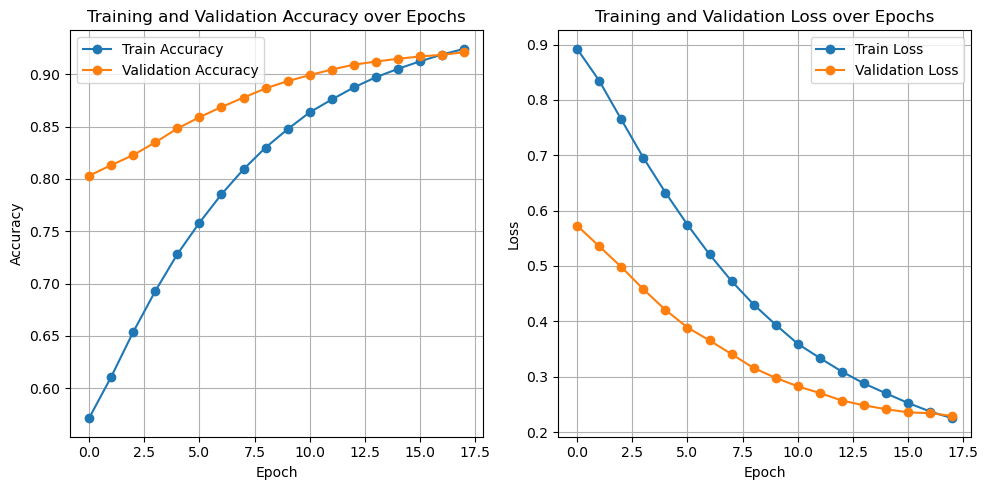

In [33]:
test_model_accuracy(model)